## Predicting CrossFit Games Ranking based on Benchmark Workout Performance

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import datatable as dt
import xlrd

In [70]:
# Read in scraped data and combine into one dataframe
folder_path = 'data/interim'  

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

dfs = []
combined_df = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

df = combined_df.loc[:,'Athlete': 'Sprint 400m']
df = df.drop_duplicates()

df.head()

,Athlete,Affiliate,Country,Competition,Placement,Region,Division,Division_2,Back Squat,Chad1000x,Clean and Jerk,Deadlift,Fight Gone Bad,Filthy 50,Fran,Grace,Helen,L1 Benchmark,Max Pull-ups,Run 5k,Snatch,Sprint 400m
0,Lin Yi,CrossFit Jaakarhu,NaN,NaN,NaN,South Central,Men,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN
1,Adam Reed,NaN,NaN,NaN,NaN,Northern California,Men,NaN,225 lb,NaN,175 lb,280 lb,NaN,NaN,NaN,NaN,NaN,NaN,2.0,24:00,NaN,1:22
2,Ryan Johnston,NaN,NaN,NaN,NaN,Northern California,Men,NaN,330 lb,NaN,215 lb,450 lb,322.0,23:26,3:02,2:26,NaN,NaN,NaN,19:22,195 lb,NaN
3,Justin Bergh,Koda CrossFit Iron View,NaN,2023 open\n4107th\nworldwide,4107th,worldwide,Men,Men (40-44),335 lb,NaN,265 lb,415 lb,393.0,21:27,3:46,2:54,8:16,NaN,32.0,22:05,210 lb,1:04
4,Lindsey Bergh,NaN,NaN,NaN,NaN,West Coast,Women,NaN,NaN,NaN,145 lb,210 lb,NaN,NaN,NaN,NaN,NaN,NaN,31.0,NaN,NaN,NaN


In [49]:
df[df['Athlete']=='Jeffrey Adler']
df[df['Athlete']=='Alex Teh']

,Athlete,Affiliate,Country,Competition,Placement,Region,Division,Division_2,Back Squat,Chad1000x,Clean and Jerk,Deadlift,Fight Gone Bad,Filthy 50,Fran,Grace,Helen,L1 Benchmark,Max Pull-ups,Run 5k,Snatch,Sprint 400m
62093,Alex Teh,NaN,NaN,NaN,NaN,Australia,Men,NaN,1 kg,NaN,1 kg,1 kg,NaN,0:01,0:01,0:01,0:01,NaN,NaN,0:01,1 kg,0:01


## Data Cleaning and Standardization

In [50]:
df.columns

Index(['Athlete', 'Affiliate', 'Country', 'Competition', 'Placement', 'Region',
       'Division', 'Division_2', 'Back Squat', 'Chad1000x', 'Clean and Jerk',
       'Deadlift', 'Fight Gone Bad', 'Filthy 50', 'Fran', 'Grace', 'Helen',
       'L1 Benchmark', 'Max Pull-ups', 'Run 5k', 'Snatch', 'Sprint 400m'],
      dtype='object')

In [71]:
df[['Event', 'Rank', 'Games_Level']] = df['Competition'].str.split('\n', expand=True)
df[['Year', 'Qualifier']] = df['Event'].str.split(' ', expand=True)
df = df.drop(columns={'Competition','Event','Placement'}, axis=1)

In [72]:
df.describe()

,Country,Fight Gone Bad,Max Pull-ups
count,0.0,21675.000000,35687.000000
mean,NaN,403.379331,201.282316
std,NaN,9603.022465,12965.298031
min,NaN,1.000000,-1.000000
25%,NaN,269.000000,20.000000
50%,NaN,308.000000,30.000000
75%,NaN,350.000000,42.000000
max,NaN,1000000.000000,1000000.000000


In [73]:
def convert_kg_to_lbs(df, column):
    lbs_to_kg = 2.20462
    df[[column, f'{column}_Unit']] = df[column].str.split(' ', expand=True)
    df[column] = df[column].astype(float)
    df.loc[df[f'{column}_Unit'] == 'kg', column] *= 2.20462
    df = df.rename(columns={column : f'{column} (lbs)'})
    df = df.drop(columns={f'{column}_Unit'})
    return df

def convert_features_to_lbs(df, column_list):
    for column in column_list:
        df = convert_kg_to_lbs(df, column)
    return df

In [74]:
features_to_convert = ['Back Squat', 'Clean and Jerk', 'Deadlift', 'Snatch'] 
df = convert_features_to_lbs(df, features_to_convert)
df[df['Athlete']=='Jeffrey Adler']

,Athlete,Affiliate,Country,Region,Division,Division_2,Back Squat (lbs),Chad1000x,Clean and Jerk (lbs),Deadlift (lbs),Fight Gone Bad,Filthy 50,Fran,Grace,Helen,L1 Benchmark,Max Pull-ups,Run 5k,Snatch (lbs),Sprint 400m,Rank,Games_Level,Year,Qualifier
40014,Jeffrey Adler,CrossFit Wonderland,NaN,worldwide,Men,Men,475.0,NaN,377.0,567.0,511.0,15:17,2:02,1:16,7:18,NaN,54.0,19:15,290.0,0:59,1st,worldwide,2023,games


In [75]:
df.describe()

,Country,Back Squat (lbs),Clean and Jerk (lbs),Deadlift (lbs),Fight Gone Bad,Max Pull-ups,Snatch (lbs)
count,0.0,77958.000000,75107.000000,79465.000000,21675.000000,35687.000000,72316.000000
mean,NaN,337.366564,238.837258,401.407653,403.379331,201.282316,190.652664
std,NaN,5345.489392,3986.214727,4676.071067,9603.022465,12965.298031,3995.022254
min,NaN,-4.000000,1.000000,-500.000000,1.000000,-1.000000,1.000000
25%,NaN,235.000000,165.346500,297.623700,269.000000,20.000000,125.000000
50%,NaN,305.000000,215.000000,374.785400,308.000000,30.000000,165.000000
75%,NaN,365.000000,255.735920,440.924000,350.000000,42.000000,200.620420
max,NaN,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000


In [76]:
df[(df[['Back Squat (lbs)', 'Clean and Jerk (lbs)',
       'Deadlift (lbs)', 'Fight Gone Bad', 'Max Pull-ups', 'Snatch (lbs)']] < 0).any(axis=1)]

,Athlete,Affiliate,Country,Region,Division,Division_2,Back Squat (lbs),Chad1000x,Clean and Jerk (lbs),Deadlift (lbs),Fight Gone Bad,Filthy 50,Fran,Grace,Helen,L1 Benchmark,Max Pull-ups,Run 5k,Snatch (lbs),Sprint 400m,Rank,Games_Level,Year,Qualifier
15964,John Mouzakis,Feast CrossFit,NaN,United States,Men,NaN,-4.0,NaN,1.0,-6.0,NaN,NaN,16666:40,16666:40,16666:40,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
19681,Clément Adam,NaN,NaN,Europe,Men,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31082,Christopher Shkreli,914 CrossFit,NaN,United States,Men,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31698,Nate Bacott,NaN,NaN,North Central,Men,NaN,120.0,NaN,95.0,135.0,NaN,NaN,12:35,NaN,21:54,NaN,-1.0,45:00,45.0,5:03,NaN,NaN,NaN,NaN
41605,Zach Morman,Vickery CrossFit,NaN,United States,Men,NaN,285.0,NaN,255.0,-500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,235.0,NaN,NaN,NaN,NaN,NaN
55024,Jason Baxter,CrossFit Durham,NaN,United States,Men,NaN,45.0,NaN,45.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,120:00,45.0,10:00,NaN,NaN,NaN,NaN


In [77]:
df = df.drop(df[df['Athlete'] == 'John Mouzakis'].index)
df = df.drop(df[df['Athlete'] == 'Christopher Shkreli'].index)
df = df.drop(df[df['Athlete'] == 'Clément Adam'].index)

df.loc[df['Athlete']=='Zach Morman', 'Deadlift (lbs)'] = 500
df.loc[df['Athlete']=='Nate Bacott', 'Max Pull-ups'] = 1
df.loc[df['Athlete']=='Jason Baxter', 'Max Pull-ups'] = 1

print(df[(df[['Back Squat (lbs)', 'Clean and Jerk (lbs)',
              'Deadlift (lbs)', 'Fight Gone Bad', 'Max Pull-ups', 'Snatch (lbs)']] < 0).any(axis=1)])
df.describe().T

Empty DataFrame
Columns: [Athlete, Affiliate, Country, Region, Division, Division_2, Back Squat (lbs), Chad1000x, Clean and Jerk (lbs), Deadlift (lbs), Fight Gone Bad, Filthy 50, Fran, Grace, Helen, L1 Benchmark, Max Pull-ups, Run 5k, Snatch (lbs), Sprint 400m, Rank, Games_Level, Year, Qualifier]
Index: []


,count,mean,std,min,25%,50%,75%,max
Country,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Back Squat (lbs),77957.0,337.370942,5345.523538,1.0,235.0000,305.0000,365.00000,1000000.0
Clean and Jerk (lbs),75106.0,238.840425,3986.241170,1.0,165.3465,215.0000,255.73592,1000000.0
Deadlift (lbs),79464.0,401.425364,4676.099187,1.0,297.6237,374.7854,440.92400,1000000.0
Fight Gone Bad,21675.0,403.379331,9603.022465,1.0,269.0000,308.0000,350.00000,1000000.0
Max Pull-ups,35685.0,201.293765,12965.661273,1.0,20.0000,30.0000,42.00000,1000000.0
Snatch (lbs),72315.0,190.655245,3995.049817,1.0,125.0000,165.0000,200.62042,1000000.0


In [78]:
df[df['Deadlift (lbs)']==1000000]

,Athlete,Affiliate,Country,Region,Division,Division_2,Back Squat (lbs),Chad1000x,Clean and Jerk (lbs),Deadlift (lbs),Fight Gone Bad,Filthy 50,Fran,Grace,Helen,L1 Benchmark,Max Pull-ups,Run 5k,Snatch (lbs),Sprint 400m,Rank,Games_Level,Year,Qualifier
55577,Jack Nash,CrossFit 306,NaN,worldwide,Men,Men,1000000.0,NaN,100000.0,1000000.0,5000.0,4:20,0:10,700:01,70:09,NaN,69.0,5:05,100001.0,-16666:0-40,42049th,worldwide,2023,open


In [79]:
benchmark_workouts = ['Back Squat (lbs)', 'Chad1000x', 'Clean and Jerk (lbs)',
                      'Deadlift (lbs)', 'Fight Gone Bad', 'Filthy 50', 'Fran', 'Grace',
                      'Helen', 'L1 Benchmark', 'Max Pull-ups', 'Run 5k', 'Snatch (lbs)','Sprint 400m']

for column in benchmark_workouts:
    df.loc[df['Athlete']=='Jack Nash', column] = np.nan
    
df[df['Athlete']=='Jack Nash']

,Athlete,Affiliate,Country,Region,Division,Division_2,Back Squat (lbs),Chad1000x,Clean and Jerk (lbs),Deadlift (lbs),Fight Gone Bad,Filthy 50,Fran,Grace,Helen,L1 Benchmark,Max Pull-ups,Run 5k,Snatch (lbs),Sprint 400m,Rank,Games_Level,Year,Qualifier
55577,Jack Nash,CrossFit 306,NaN,worldwide,Men,Men,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42049th,worldwide,2023,open


In [80]:
df['Sprint 400m'] = df['Sprint 400m'].replace(to_replace=['-', r'.*-.*','16666:40'], value=np.nan, regex=True)

for column in benchmark_workouts:
    df[column] = df[column].replace(to_replace=['16666:40'], value=np.nan, regex=True)

In [81]:
print(min(df['Fight Gone Bad'].dropna().unique()))
print(max(df['Fight Gone Bad'].dropna().unique()))

1.0
1000000.0


In [82]:
# Remove unreasonable numbers
df['Fight Gone Bad'] = np.where(df['Fight Gone Bad']>=999, np.nan, df['Fight Gone Bad'])
df['Back Squat (lbs)'] = np.where(df['Back Squat (lbs)']>=1157, np.nan, df['Back Squat (lbs)'])
df['Clean and Jerk (lbs)'] = np.where(df['Clean and Jerk (lbs)']>=589, np.nan, df['Clean and Jerk (lbs)'])
df['Deadlift (lbs)'] = np.where(df['Deadlift (lbs)']>=1201, np.nan, df['Deadlift (lbs)'])
df['Max Pull-ups'] = np.where(df['Max Pull-ups']>=651, np.nan, df['Max Pull-ups'])
df['Snatch (lbs)'] = np.where(df['Snatch (lbs)']>=496, np.nan, df['Snatch (lbs)'])

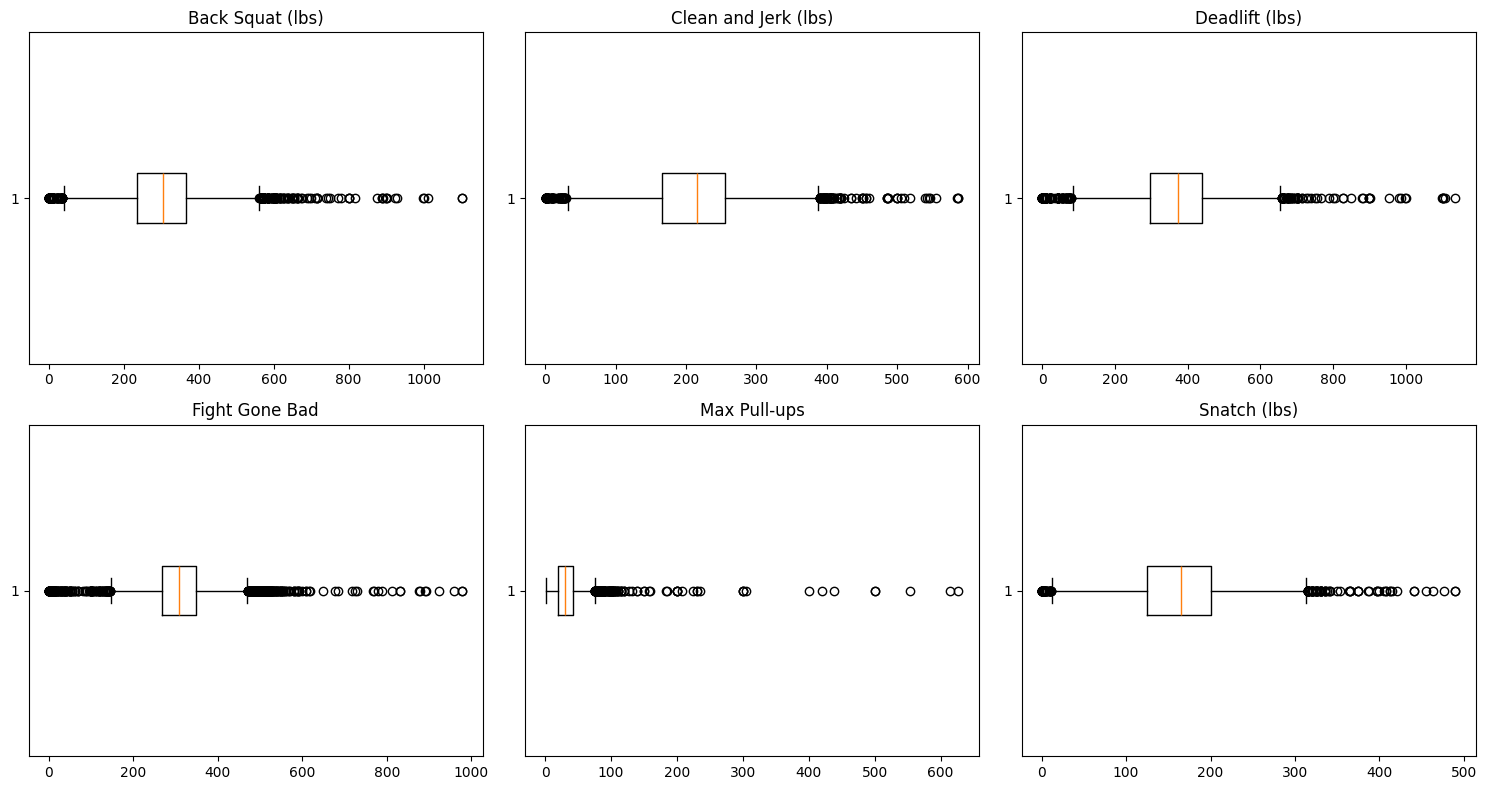

In [61]:
columns_to_plot = ['Back Squat (lbs)', 'Clean and Jerk (lbs)',
                   'Deadlift (lbs)', 'Fight Gone Bad',
                   'Max Pull-ups', 'Snatch (lbs)']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    axes[i].boxplot(df[column].dropna(), vert=False)
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

In [62]:
for columns in columns_to_plot:
    print(columns)
    print(df[columns].describe())
    print()

Back Squat (lbs)
count    77939.000000
mean       302.474341
std         86.957684
min          1.000000
25%        235.000000
50%        305.000000
75%        365.000000
max       1102.310000
Name: Back Squat (lbs), dtype: float64

Clean and Jerk (lbs)
count    75066.000000
mean       213.961156
std         61.488128
min          1.000000
25%        165.346500
50%        215.000000
75%        255.000000
max        587.000000
Name: Clean and Jerk (lbs), dtype: float64

Deadlift (lbs)
count    79437.000000
mean       368.349150
std         97.224769
min          1.000000
25%        297.623700
50%        374.785400
75%        440.924000
max       1135.379300
Name: Deadlift (lbs), dtype: float64

Fight Gone Bad
count    21656.000000
mean       310.015192
std         68.645433
min          1.000000
25%        268.000000
50%        308.000000
75%        349.000000
max        978.000000
Name: Fight Gone Bad, dtype: float64

Max Pull-ups
count    35654.000000
mean        31.997981
std        

In [83]:
time_based_workouts = ['Chad1000x', 'Filthy 50', 'Fran', 'Grace',
                      'Helen', 'L1 Benchmark', 'Run 5k', 'Sprint 400m']

In [84]:
def convert_time_to_seconds(time_str):
    if pd.isna(time_str):
        return np.nan

    time_parts = time_str.split(':')

    if len(time_parts) == 3:
        # For formats with three parts (xx:xx:xx), strip trailing ':00'
        time_str = str(time_str).rstrip(':00')
        time_parts = time_str.split(':')

    if len(time_parts) == 1:
        # Treat as minutes if there's only one part
        minutes = int(time_parts[0].zfill(2))
        total_seconds = minutes * 60
    elif len(time_parts) == 2:
        # Treat as minutes and seconds if there are two parts
        minutes, seconds = map(lambda x: int(x.zfill(2)), time_parts)
        total_seconds = minutes * 60 + seconds
    else:
        raise ValueError("Invalid time format: {}".format(time_str))

    return total_seconds

def convert_columns_to_seconds(df, columns_list):
    for column in columns_list:
        df[column + ' (s)'] = df[column].apply(convert_time_to_seconds)
        #df = df.drop(columns={column})
    return df

df = convert_columns_to_seconds(df, time_based_workouts)
df.head()

,Athlete,Affiliate,Country,Region,Division,Division_2,Back Squat (lbs),Chad1000x,Clean and Jerk (lbs),Deadlift (lbs),Fight Gone Bad,Filthy 50,Fran,Grace,Helen,L1 Benchmark,Max Pull-ups,Run 5k,Snatch (lbs),Sprint 400m,Rank,Games_Level,Year,Qualifier,Chad1000x (s),Filthy 50 (s),Fran (s),Grace (s),Helen (s),L1 Benchmark (s),Run 5k (s),Sprint 400m (s)
0,Lin Yi,CrossFit Jaakarhu,NaN,South Central,Men,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Adam Reed,NaN,NaN,Northern California,Men,NaN,225.0,NaN,175.0,280.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,24:00,NaN,1:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1440.0,82.0
2,Ryan Johnston,NaN,NaN,Northern California,Men,NaN,330.0,NaN,215.0,450.0,322.0,23:26,3:02,2:26,NaN,NaN,NaN,19:22,195.0,NaN,NaN,NaN,NaN,NaN,NaN,1406.0,182.0,146.0,NaN,NaN,1162.0,NaN
3,Justin Bergh,Koda CrossFit Iron View,NaN,worldwide,Men,Men (40-44),335.0,NaN,265.0,415.0,393.0,21:27,3:46,2:54,8:16,NaN,32.0,22:05,210.0,1:04,4107th,worldwide,2023,open,NaN,1287.0,226.0,174.0,496.0,NaN,1325.0,64.0
4,Lindsey Bergh,NaN,NaN,West Coast,Women,NaN,NaN,NaN,145.0,210.0,NaN,NaN,NaN,NaN,NaN,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
df = df.sort_values(by='Chad1000x (s)')
df[(~df['Chad1000x'].isna()) & (df['Chad1000x (s)']<1600)]

,Athlete,Affiliate,Country,Region,Division,Division_2,Back Squat (lbs),Chad1000x,Clean and Jerk (lbs),Deadlift (lbs),Fight Gone Bad,Filthy 50,Fran,Grace,Helen,L1 Benchmark,Max Pull-ups,Run 5k,Snatch (lbs),Sprint 400m,Rank,Games_Level,Year,Qualifier,Chad1000x (s),Filthy 50 (s),Fran (s),Grace (s),Helen (s),L1 Benchmark (s),Run 5k (s),Sprint 400m (s)
912,Emilie St-Pierre,CrossFit Vaudreuil,NaN,worldwide,Women,Women (40-44),190.00000,0:01,120.00000,245.0000,NaN,NaN,NaN,9:07,11:47,NaN,15.0,NaN,92.00000,1:29,10474th,worldwide,2023,open,1.0,NaN,NaN,547.0,707.0,NaN,NaN,89.0
58255,John Zvejnieks,CrossFit East Nashville,NaN,North America,Men,NaN,666.00000,0:10,NaN,666.0000,101.0,0:10,0:10,0:10,0:10,0:10,NaN,10:10,NaN,0:10,NaN,NaN,NaN,NaN,10.0,10.0,10.0,10.0,10.0,10.0,610.0,10.0
88735,Gilberto Santos,NaN,NaN,worldwide,Men,Men (35-39),352.73920,0:40,NaN,396.8316,NaN,NaN,NaN,NaN,NaN,NaN,45.0,22:00,NaN,1:30,649th,worldwide,2023,quarterfinals,40.0,NaN,NaN,NaN,NaN,NaN,1320.0,90.0
77539,Ivan Patoni,La Fortezza CrossFit,NaN,worldwide,Men,Men (40-44),355.00000,1:05,275.00000,485.0000,NaN,22:15,3:54,3:47,NaN,NaN,30.0,26:28,195.00000,1:29,11423rd,worldwide,2023,open,65.0,1335.0,234.0,227.0,NaN,NaN,1588.0,89.0
43494,Marshall Hopkins,CrossFit Vertical,NaN,North America East,Men,NaN,205.00000,1:08,145.00000,235.0000,208.0,NaN,NaN,6:04,14:26,NaN,1.0,28:29,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN,NaN,364.0,866.0,NaN,1709.0,NaN
45975,Bryan Veilleux,SRA CrossFit,NaN,Mid Atlantic,Men,NaN,285.00000,1:16,185.00000,305.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.00000,NaN,NaN,NaN,NaN,NaN,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92139,Remi Amar,Healthy Factory CrossFit,NaN,worldwide,Men,Men,346.12534,1:32,266.75902,440.9240,NaN,NaN,3:49,NaN,NaN,NaN,NaN,NaN,202.82504,NaN,33185th,worldwide,2023,open,92.0,NaN,229.0,NaN,NaN,NaN,NaN,NaN
29818,Andrea Junca,CrossFit Dwala,NaN,worldwide,Women,Women (40-44),260.00000,1:40,165.00000,315.0000,NaN,NaN,6:09,3:04,NaN,NaN,NaN,NaN,117.00000,NaN,5027th,worldwide,2023,open,100.0,NaN,369.0,184.0,NaN,NaN,NaN,NaN
90669,Jessica Winchester,CrossFit Loose Cannon,NaN,Oceania,Women,NaN,NaN,2:26,NaN,220.4620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29:30,66.13860,NaN,NaN,NaN,NaN,NaN,146.0,NaN,NaN,NaN,NaN,NaN,1770.0,NaN


In [86]:
def edit_data(index, colname, value):
    df.at[index, colname] = value

edit_data(46205,'Chad1000x','65:00')
edit_data(46205,'Chad1000x (s)', convert_time_to_seconds('65:00'))
edit_data(8960,'Chad1000x','68:00')
edit_data(8960,'Chad1000x (s)', convert_time_to_seconds('68:00'))
edit_data(90974,'Chad1000x','76:00')
edit_data(90974,'Chad1000x (s)', convert_time_to_seconds('76:00'))
edit_data(59680,'Chad1000x','92:00')
edit_data(59680,'Chad1000x (s)', convert_time_to_seconds('92:00'))
edit_data(35716,'Chad1000x','100:00')
edit_data(35716,'Chad1000x (s)', 6000)
edit_data(56028,'Chad1000x','146:00')
edit_data(56028,'Chad1000x (s)', 8760)

edit_data(61174,'Chad1000x (s)', np.nan)
edit_data(26644,'Chad1000x (s)', np.nan)
edit_data(47619,'Chad1000x (s)', np.nan)

df[(~df['Chad1000x'].isna()) & (df['Chad1000x (s)']<1600)]

,Athlete,Affiliate,Country,Region,Division,Division_2,Back Squat (lbs),Chad1000x,Clean and Jerk (lbs),Deadlift (lbs),Fight Gone Bad,Filthy 50,Fran,Grace,Helen,L1 Benchmark,Max Pull-ups,Run 5k,Snatch (lbs),Sprint 400m,Rank,Games_Level,Year,Qualifier,Chad1000x (s),Filthy 50 (s),Fran (s),Grace (s),Helen (s),L1 Benchmark (s),Run 5k (s),Sprint 400m (s)
912,Emilie St-Pierre,CrossFit Vaudreuil,NaN,worldwide,Women,Women (40-44),190.00000,0:01,120.00000,245.0000,NaN,NaN,NaN,9:07,11:47,NaN,15.0,NaN,92.00000,1:29,10474th,worldwide,2023,open,1.0,NaN,NaN,547.0,707.0,NaN,NaN,89.0
58255,John Zvejnieks,CrossFit East Nashville,NaN,North America,Men,NaN,666.00000,0:10,NaN,666.0000,101.0,0:10,0:10,0:10,0:10,0:10,NaN,10:10,NaN,0:10,NaN,NaN,NaN,NaN,10.0,10.0,10.0,10.0,10.0,10.0,610.0,10.0
88735,Gilberto Santos,NaN,NaN,worldwide,Men,Men (35-39),352.73920,0:40,NaN,396.8316,NaN,NaN,NaN,NaN,NaN,NaN,45.0,22:00,NaN,1:30,649th,worldwide,2023,quarterfinals,40.0,NaN,NaN,NaN,NaN,NaN,1320.0,90.0
77539,Ivan Patoni,La Fortezza CrossFit,NaN,worldwide,Men,Men (40-44),355.00000,1:05,275.00000,485.0000,NaN,22:15,3:54,3:47,NaN,NaN,30.0,26:28,195.00000,1:29,11423rd,worldwide,2023,open,65.0,1335.0,234.0,227.0,NaN,NaN,1588.0,89.0
43494,Marshall Hopkins,CrossFit Vertical,NaN,North America East,Men,NaN,205.00000,1:08,145.00000,235.0000,208.0,NaN,NaN,6:04,14:26,NaN,1.0,28:29,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN,NaN,364.0,866.0,NaN,1709.0,NaN
45975,Bryan Veilleux,SRA CrossFit,NaN,Mid Atlantic,Men,NaN,285.00000,1:16,185.00000,305.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.00000,NaN,NaN,NaN,NaN,NaN,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92139,Remi Amar,Healthy Factory CrossFit,NaN,worldwide,Men,Men,346.12534,1:32,266.75902,440.9240,NaN,NaN,3:49,NaN,NaN,NaN,NaN,NaN,202.82504,NaN,33185th,worldwide,2023,open,92.0,NaN,229.0,NaN,NaN,NaN,NaN,NaN
29818,Andrea Junca,CrossFit Dwala,NaN,worldwide,Women,Women (40-44),260.00000,1:40,165.00000,315.0000,NaN,NaN,6:09,3:04,NaN,NaN,NaN,NaN,117.00000,NaN,5027th,worldwide,2023,open,100.0,NaN,369.0,184.0,NaN,NaN,NaN,NaN
90669,Jessica Winchester,CrossFit Loose Cannon,NaN,Oceania,Women,NaN,NaN,2:26,NaN,220.4620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29:30,66.13860,NaN,NaN,NaN,NaN,NaN,146.0,NaN,NaN,NaN,NaN,NaN,1770.0,NaN


In [87]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Country,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Back Squat (lbs),77939.0,302.474341,86.957684,1.0,235.0000,305.0000,365.00000,1102.31000
Clean and Jerk (lbs),75066.0,213.961156,61.488128,1.0,165.3465,215.0000,255.00000,587.00000
Deadlift (lbs),79437.0,368.349150,97.224769,1.0,297.6237,374.7854,440.92400,1135.37930
Fight Gone Bad,21656.0,310.015192,68.645433,1.0,268.0000,308.0000,349.00000,978.00000
Max Pull-ups,35654.0,31.997981,18.585165,1.0,20.0000,30.0000,42.00000,627.00000
Snatch (lbs),72280.0,164.938205,51.210787,1.0,125.0000,165.0000,200.62042,489.42564
Chad1000x (s),549.0,3992.180328,1059.335478,1.0,3400.0000,3872.0000,4515.00000,8956.00000
Filthy 50 (s),15003.0,1586.306672,826.105346,1.0,1296.0000,1519.0000,1776.00000,60000.00000
Fran (s),45791.0,302.140661,1458.098814,1.0,186.0000,254.0000,346.00000,259200.00000


In [88]:
edit_data(37306,'Grace (s)', np.nan)

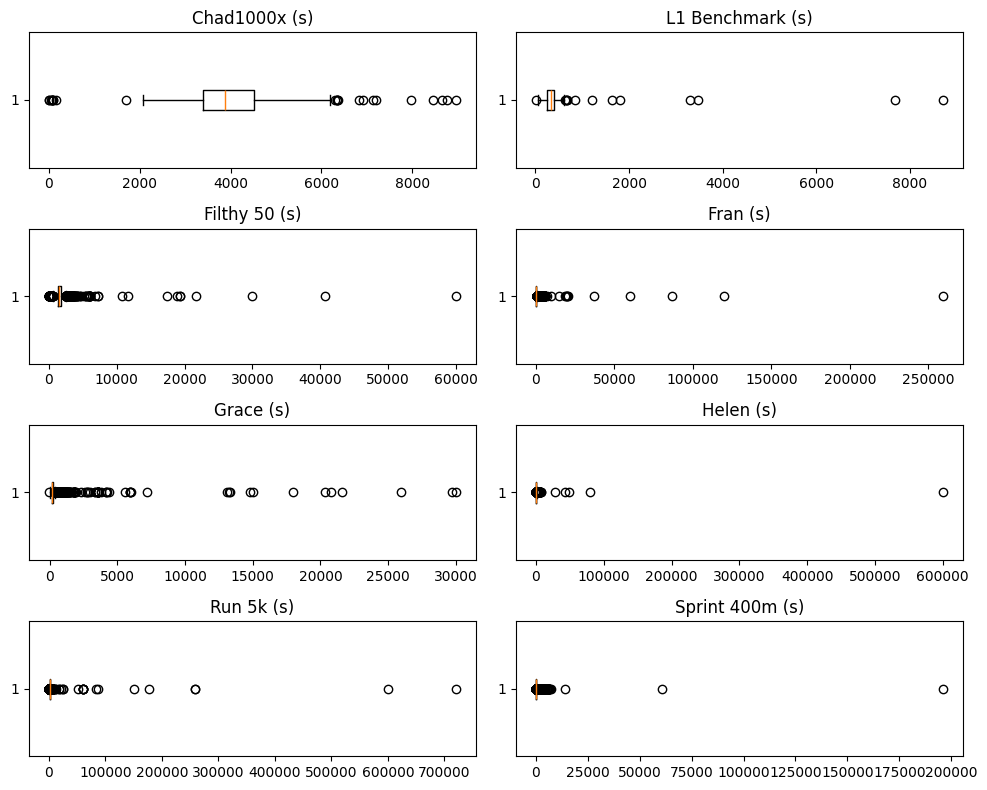

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 8))

axes = axes.flatten()

time_based_workouts = ['Chad1000x (s)', 'L1 Benchmark (s)', 'Filthy 50 (s)', 'Fran (s)',
                       'Grace (s)', 'Helen (s)', 'Run 5k (s)', 'Sprint 400m (s)']

for i, column in enumerate(time_based_workouts):
    axes[i].boxplot(df[column].dropna(), vert=False)
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

In [89]:
df['Rank'] = df['Rank'].replace({'th': '', 'nd': '', 'st': '', 'rd': ''}, regex=True).astype(float)
df.head()

,Athlete,Affiliate,Country,Region,Division,Division_2,Back Squat (lbs),Chad1000x,Clean and Jerk (lbs),Deadlift (lbs),Fight Gone Bad,Filthy 50,Fran,Grace,Helen,L1 Benchmark,Max Pull-ups,Run 5k,Snatch (lbs),Sprint 400m,Rank,Games_Level,Year,Qualifier,Chad1000x (s),Filthy 50 (s),Fran (s),Grace (s),Helen (s),L1 Benchmark (s),Run 5k (s),Sprint 400m (s)
912,Emilie St-Pierre,CrossFit Vaudreuil,NaN,worldwide,Women,Women (40-44),190.0000,0:01,120.0,245.0000,NaN,NaN,NaN,9:07,11:47,NaN,15.0,NaN,92.0,1:29,10474.0,worldwide,2023,open,1.0,NaN,NaN,547.0,707.0,NaN,NaN,89.0
58255,John Zvejnieks,CrossFit East Nashville,NaN,North America,Men,NaN,666.0000,0:10,NaN,666.0000,101.0,0:10,0:10,0:10,0:10,0:10,NaN,10:10,NaN,0:10,NaN,NaN,NaN,NaN,10.0,10.0,10.0,10.0,10.0,10.0,610.0,10.0
88735,Gilberto Santos,NaN,NaN,worldwide,Men,Men (35-39),352.7392,0:40,NaN,396.8316,NaN,NaN,NaN,NaN,NaN,NaN,45.0,22:00,NaN,1:30,649.0,worldwide,2023,quarterfinals,40.0,NaN,NaN,NaN,NaN,NaN,1320.0,90.0
77539,Ivan Patoni,La Fortezza CrossFit,NaN,worldwide,Men,Men (40-44),355.0000,1:05,275.0,485.0000,NaN,22:15,3:54,3:47,NaN,NaN,30.0,26:28,195.0,1:29,11423.0,worldwide,2023,open,65.0,1335.0,234.0,227.0,NaN,NaN,1588.0,89.0
43494,Marshall Hopkins,CrossFit Vertical,NaN,North America East,Men,NaN,205.0000,1:08,145.0,235.0000,208.0,NaN,NaN,6:04,14:26,NaN,1.0,28:29,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN,NaN,364.0,866.0,NaN,1709.0,NaN


In [90]:
benchmark_workouts = ['Back Squat (lbs)', 'Chad1000x (s)', 'Clean and Jerk (lbs)',
                      'Deadlift (lbs)', 'Fight Gone Bad', 'L1 Benchmark (s)', 'Max Pull-ups',
                      'Snatch (lbs)','Filthy 50 (s)', 'Fran (s)', 'Grace (s)', 'Helen (s)', 
                      'Run 5k (s)','Sprint 400m (s)']
len(benchmark_workouts)

14

In [91]:
def edit_typo_negative(df, column):
    df.loc[df[column] < 0, column] *= -1
    return df

def edit_typo_negatives_list(df, column_list):
    for column in column_list:
        df = edit_typo_negative(df, column)
    return df

df = edit_typo_negatives_list(df, benchmark_workouts)
# df.to_excel('data_.xlsx',index=False)
df

,Athlete,Affiliate,Country,Region,Division,Division_2,Back Squat (lbs),Chad1000x,Clean and Jerk (lbs),Deadlift (lbs),Fight Gone Bad,Filthy 50,Fran,Grace,Helen,L1 Benchmark,Max Pull-ups,Run 5k,Snatch (lbs),Sprint 400m,Rank,Games_Level,Year,Qualifier,Chad1000x (s),Filthy 50 (s),Fran (s),Grace (s),Helen (s),L1 Benchmark (s),Run 5k (s),Sprint 400m (s)
912,Emilie St-Pierre,CrossFit Vaudreuil,NaN,worldwide,Women,Women (40-44),190.0000,0:01,120.0,245.0000,NaN,NaN,NaN,9:07,11:47,NaN,15.0,NaN,92.0000,1:29,10474.0,worldwide,2023,open,1.0,NaN,NaN,547.0,707.0,NaN,NaN,89.0
58255,John Zvejnieks,CrossFit East Nashville,NaN,North America,Men,NaN,666.0000,0:10,NaN,666.0000,101.0,0:10,0:10,0:10,0:10,0:10,NaN,10:10,NaN,0:10,NaN,NaN,NaN,NaN,10.0,10.0,10.0,10.0,10.0,10.0,610.0,10.0
88735,Gilberto Santos,NaN,NaN,worldwide,Men,Men (35-39),352.7392,0:40,NaN,396.8316,NaN,NaN,NaN,NaN,NaN,NaN,45.0,22:00,NaN,1:30,649.0,worldwide,2023,quarterfinals,40.0,NaN,NaN,NaN,NaN,NaN,1320.0,90.0
77539,Ivan Patoni,La Fortezza CrossFit,NaN,worldwide,Men,Men (40-44),355.0000,1:05,275.0,485.0000,NaN,22:15,3:54,3:47,NaN,NaN,30.0,26:28,195.0000,1:29,11423.0,worldwide,2023,open,65.0,1335.0,234.0,227.0,NaN,NaN,1588.0,89.0
43494,Marshall Hopkins,CrossFit Vertical,NaN,North America East,Men,NaN,205.0000,1:08,145.0,235.0000,208.0,NaN,NaN,6:04,14:26,NaN,1.0,28:29,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN,NaN,364.0,866.0,NaN,1709.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93685,Karenna Umscheid,CrossFit Reflexion,NaN,United States,Women,NaN,135.0000,NaN,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29:47,105.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1787.0,NaN
93686,Emily Rosberger,CrossFit Gladbeck,NaN,Germany,Women,NaN,NaN,NaN,NaN,198.4158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.1848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93687,Rogelio Trujillo,NaN,NaN,North America,Men,NaN,335.0000,NaN,270.0,420.0000,NaN,NaN,3:40,2:34,NaN,NaN,25.0,15:50,240.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.0,154.0,NaN,NaN,950.0,NaN
47619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
df = pd.read_excel('data/interim/data.xlsx')
# df = dt.fread("data.xlsx").to_pandas()
df

,Athlete,Affiliate,Country,Region,Division,Back Squat (lbs),Chad1000x,Clean and Jerk (lbs),Deadlift (lbs),Fight Gone Bad,Filthy 50,Fran,Grace,Helen,L1 Benchmark,Max Pull-ups,Run 5k,Snatch (lbs),Sprint 400m,Rank,Games_Level,Year,Qualifier,Chad1000x (s),L1 Benchmark (s),Filthy 50 (s),Fran (s),Grace (s),Helen (s),Run 5k (s),Sprint 400m (s)
0,Yagiz Diyaroglu,NaN,NaN,Africa,Boys (14-15),187.3927,NaN,NaN,242.50820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jandré Erasmus,NaN,NaN,Africa,Boys (16-17),265.0000,NaN,174.00000,342.00000,NaN,NaN,NaN,NaN,NaN,NaN,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Roan van Heerden,CrossFit 10 Star,NaN,Africa,Men,220.4620,NaN,176.36960,264.55440,291.0,NaN,9:00,NaN,NaN,NaN,1.0,40:00,132.27720,2:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,540.0,NaN,NaN,2400.0,120.0
3,David Swarts,Cape CrossFit,NaN,Africa,Men,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Colin Pinkham,NaN,NaN,Africa,Men,264.5544,NaN,163.14188,365.96692,NaN,NaN,NaN,NaN,NaN,NaN,3.0,28:51,103.61714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1731.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85326,Troels Kjær Aaskilde,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1196.0,NaN
85327,Wafik Abed El Malak,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1220.0,NaN
85328,Will Marshall,CrossFit Athletics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4:12,NaN,NaN,NaN,NaN,NaN,187.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,NaN,NaN,NaN
85329,Wouter Vanloffelt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19:45,NaN,1:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1185.0,64.0


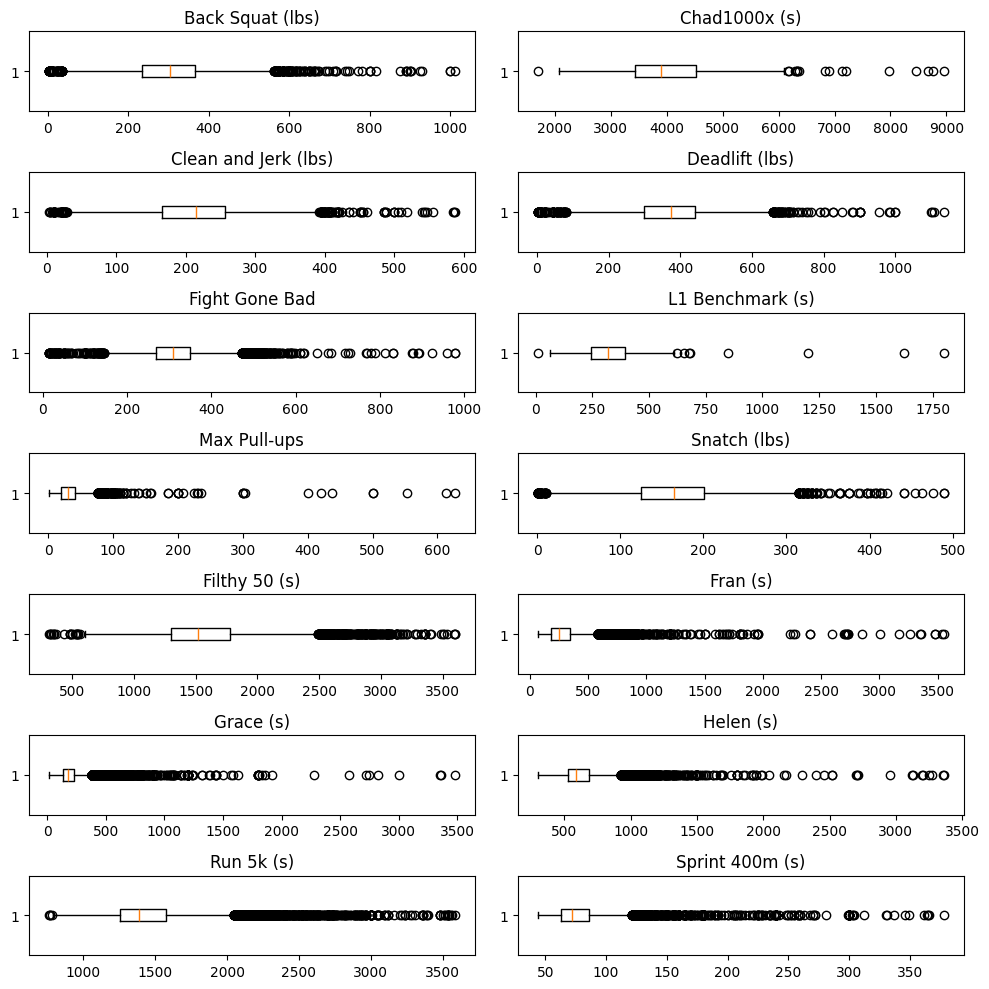

In [33]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(10, 10))

axes = axes.flatten()

for i, column in enumerate(benchmark_workouts):
    axes[i].boxplot(df[column].dropna(), vert=False)
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

In [93]:
df.columns

Index(['Athlete', 'Affiliate', 'Country', 'Region', 'Division',
       'Back Squat (lbs)', 'Chad1000x', 'Clean and Jerk (lbs)',
       'Deadlift (lbs)', 'Fight Gone Bad', 'Filthy 50', 'Fran', 'Grace',
       'Helen', 'L1 Benchmark', 'Max Pull-ups', 'Run 5k', 'Snatch (lbs)',
       'Sprint 400m', 'Rank', 'Games_Level', 'Year', 'Qualifier',
       'Chad1000x (s)', 'L1 Benchmark (s)', 'Filthy 50 (s)', 'Fran (s)',
       'Grace (s)', 'Helen (s)', 'Run 5k (s)', 'Sprint 400m (s)'],
      dtype='object')

In [94]:
df = df.drop(columns={'Chad1000x','Filthy 50', 'Fran', 'Grace','Helen', 'L1 Benchmark','Run 5k','Sprint 400m'})
df = df[['Athlete', 'Affiliate', 'Country', 'Region', 'Division','Rank', 'Games_Level',
       'Year', 'Qualifier','Back Squat (lbs)', 'Clean and Jerk (lbs)', 'Deadlift (lbs)','Snatch (lbs)',
       'Fight Gone Bad', 'Max Pull-ups','Chad1000x (s)', 'L1 Benchmark (s)',
       'Filthy 50 (s)', 'Fran (s)', 'Grace (s)', 'Helen (s)', 'Run 5k (s)','Sprint 400m (s)']]
df

,Athlete,Affiliate,Country,Region,Division,Rank,Games_Level,Year,Qualifier,Back Squat (lbs),Clean and Jerk (lbs),Deadlift (lbs),Snatch (lbs),Fight Gone Bad,Max Pull-ups,Chad1000x (s),L1 Benchmark (s),Filthy 50 (s),Fran (s),Grace (s),Helen (s),Run 5k (s),Sprint 400m (s)
0,Yagiz Diyaroglu,NaN,NaN,Africa,Boys (14-15),NaN,NaN,NaN,NaN,187.3927,NaN,242.50820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jandré Erasmus,NaN,NaN,Africa,Boys (16-17),NaN,NaN,NaN,NaN,265.0000,174.00000,342.00000,NaN,NaN,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Roan van Heerden,CrossFit 10 Star,NaN,Africa,Men,NaN,NaN,NaN,NaN,220.4620,176.36960,264.55440,132.27720,291.0,1.0,NaN,NaN,NaN,540.0,NaN,NaN,2400.0,120.0
3,David Swarts,Cape CrossFit,NaN,Africa,Men,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Colin Pinkham,NaN,NaN,Africa,Men,NaN,NaN,NaN,NaN,264.5544,163.14188,365.96692,103.61714,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1731.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85326,Troels Kjær Aaskilde,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1196.0,NaN
85327,Wafik Abed El Malak,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1220.0,NaN
85328,Will Marshall,CrossFit Athletics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.00000,NaN,NaN,NaN,NaN,NaN,252.0,NaN,NaN,NaN,NaN
85329,Wouter Vanloffelt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1185.0,64.0


In [95]:
df_ = df.copy()
def remove_outliers_zscore(df_, columns):
    for col in columns:
        z_scores = stats.zscore(df_[col])
        df_[col] = df_[col][(z_scores < 3) & (z_scores > -3)]
    return df_

df_no_outliers_zscore = remove_outliers_zscore(df_, benchmark_workouts)
df_no_outliers_zscore

def remove_outliers_iqr(df_, columns, threshold):
    for col in columns:
        Q1 = df_[col].quantile(0.25)
        Q3 = df_[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df_[col] = df_[col][(df_[col] >= lower_bound) & (df_[col] <= upper_bound)]
    return df

df_no_outliers_iqr = remove_outliers_iqr(df_, benchmark_workouts, 1)
df_no_outliers_iqr

,Athlete,Affiliate,Country,Region,Division,Rank,Games_Level,Year,Qualifier,Back Squat (lbs),Clean and Jerk (lbs),Deadlift (lbs),Snatch (lbs),Fight Gone Bad,Max Pull-ups,Chad1000x (s),L1 Benchmark (s),Filthy 50 (s),Fran (s),Grace (s),Helen (s),Run 5k (s),Sprint 400m (s)
0,Yagiz Diyaroglu,NaN,NaN,Africa,Boys (14-15),NaN,NaN,NaN,NaN,187.3927,NaN,242.50820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jandré Erasmus,NaN,NaN,Africa,Boys (16-17),NaN,NaN,NaN,NaN,265.0000,174.00000,342.00000,NaN,NaN,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Roan van Heerden,CrossFit 10 Star,NaN,Africa,Men,NaN,NaN,NaN,NaN,220.4620,176.36960,264.55440,132.27720,291.0,1.0,NaN,NaN,NaN,540.0,NaN,NaN,2400.0,120.0
3,David Swarts,Cape CrossFit,NaN,Africa,Men,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Colin Pinkham,NaN,NaN,Africa,Men,NaN,NaN,NaN,NaN,264.5544,163.14188,365.96692,103.61714,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1731.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85326,Troels Kjær Aaskilde,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1196.0,NaN
85327,Wafik Abed El Malak,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1220.0,NaN
85328,Will Marshall,CrossFit Athletics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.00000,NaN,NaN,NaN,NaN,NaN,252.0,NaN,NaN,NaN,NaN
85329,Wouter Vanloffelt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1185.0,64.0


## Exploratory Data Analysis

In [96]:
df[benchmark_workouts].describe().T.style.bar(
    subset=["mean"], color="#205ff2"
).background_gradient(subset=["std"], cmap="Reds"
).background_gradient(subset=["50%"], cmap="coolwarm").format("{:.1f}")

,count,mean,std,min,25%,50%,75%,max
Back Squat (lbs),77871.0,302.7,86.5,3.0,235.0,305.0,365.0,1012.0
Chad1000x (s),540.0,4057.6,937.7,1695.0,3430.8,3896.5,4516.8,8956.0
Clean and Jerk (lbs),74999.0,214.2,61.2,3.0,165.3,215.0,255.7,587.0
Deadlift (lbs),79377.0,368.6,96.7,3.0,297.6,374.8,440.9,1135.4
Fight Gone Bad,21587.0,311.0,66.5,15.0,269.0,309.0,350.0,978.0
L1 Benchmark (s),149.0,357.5,215.5,10.0,245.0,321.0,395.0,1800.0
Max Pull-ups,35654.0,32.0,18.6,1.0,20.0,30.0,42.0,627.0
Snatch (lbs),72280.0,164.9,51.2,1.0,125.0,165.0,200.6,489.4
Filthy 50 (s),14898.0,1567.2,377.3,310.0,1298.0,1519.0,1774.0,3599.0
Fran (s),45710.0,284.9,144.1,72.0,186.0,254.0,346.0,3552.0


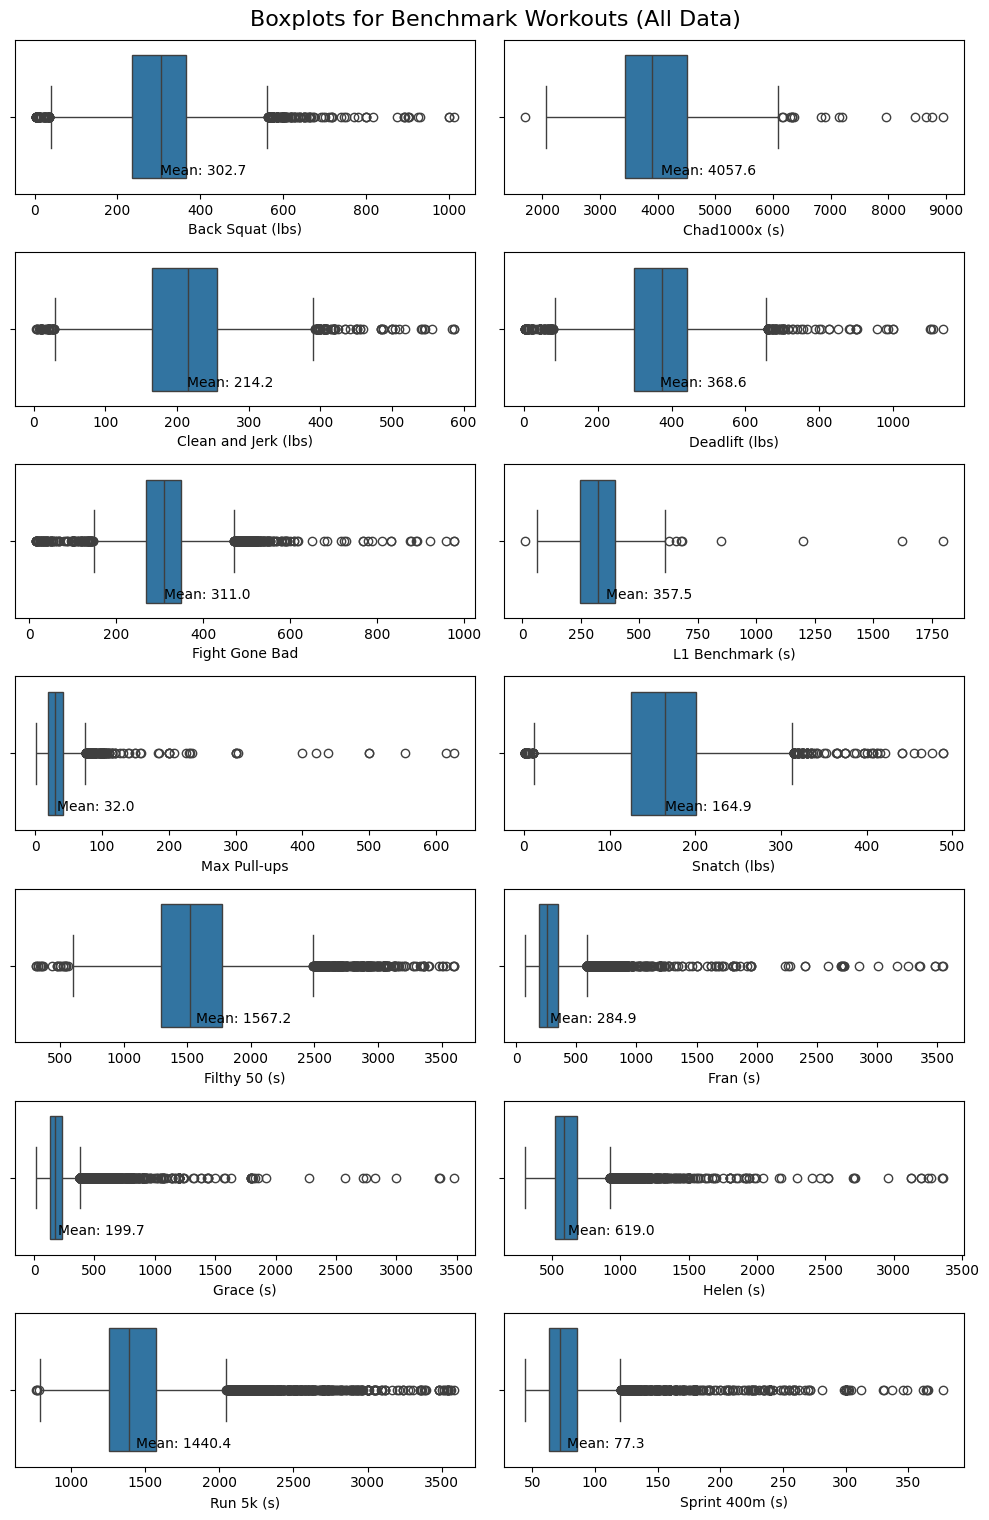

In [42]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(10, 15))

axes = axes.flatten()

summary_stats = pd.DataFrame(columns=['Workout', 'Mean', 'Median','Min', '25%', '50%', '75%', 'Max'])

for i, column in enumerate(benchmark_workouts):
    df[column] = pd.to_numeric(df[column], errors='coerce')
    df[column].dropna(inplace=True)
    
    sns.boxplot(x=df[column], ax=axes[i], orient='horizontal') 
#     axes[i].set_title(column)
    
    mean_value = round(df[column].mean(),1)
    axes[i].text(mean_value, 0.35, f'Mean: {mean_value}', color='black', verticalalignment='center')

    mean_value = df[column].mean()
    median_value = df[column].median()
    q25 = df[column].quantile(0.25)
    q50 = df[column].quantile(0.50)
    q75 = df[column].quantile(0.75)
    min_value = df[column].min()
    max_value = df[column].max()
    
    summary_stats = pd.concat([summary_stats, 
                            pd.DataFrame({'Workout': [column], 
                                          'Mean': [mean_value],
                                          'Median': [median_value],
                                          'Min': [min_value],
                                          '25%': [q25], 
                                          '50%': [q50], 
                                          '75%': [q75],
                                          'Max': [max_value]})])

plt.tight_layout()
fig.suptitle('Boxplots for Benchmark Workouts (All Data)', y=1.01, fontsize=16)
fig.savefig('reports/figures/boxplots_benchmark_workouts_all.png')

plt.show()

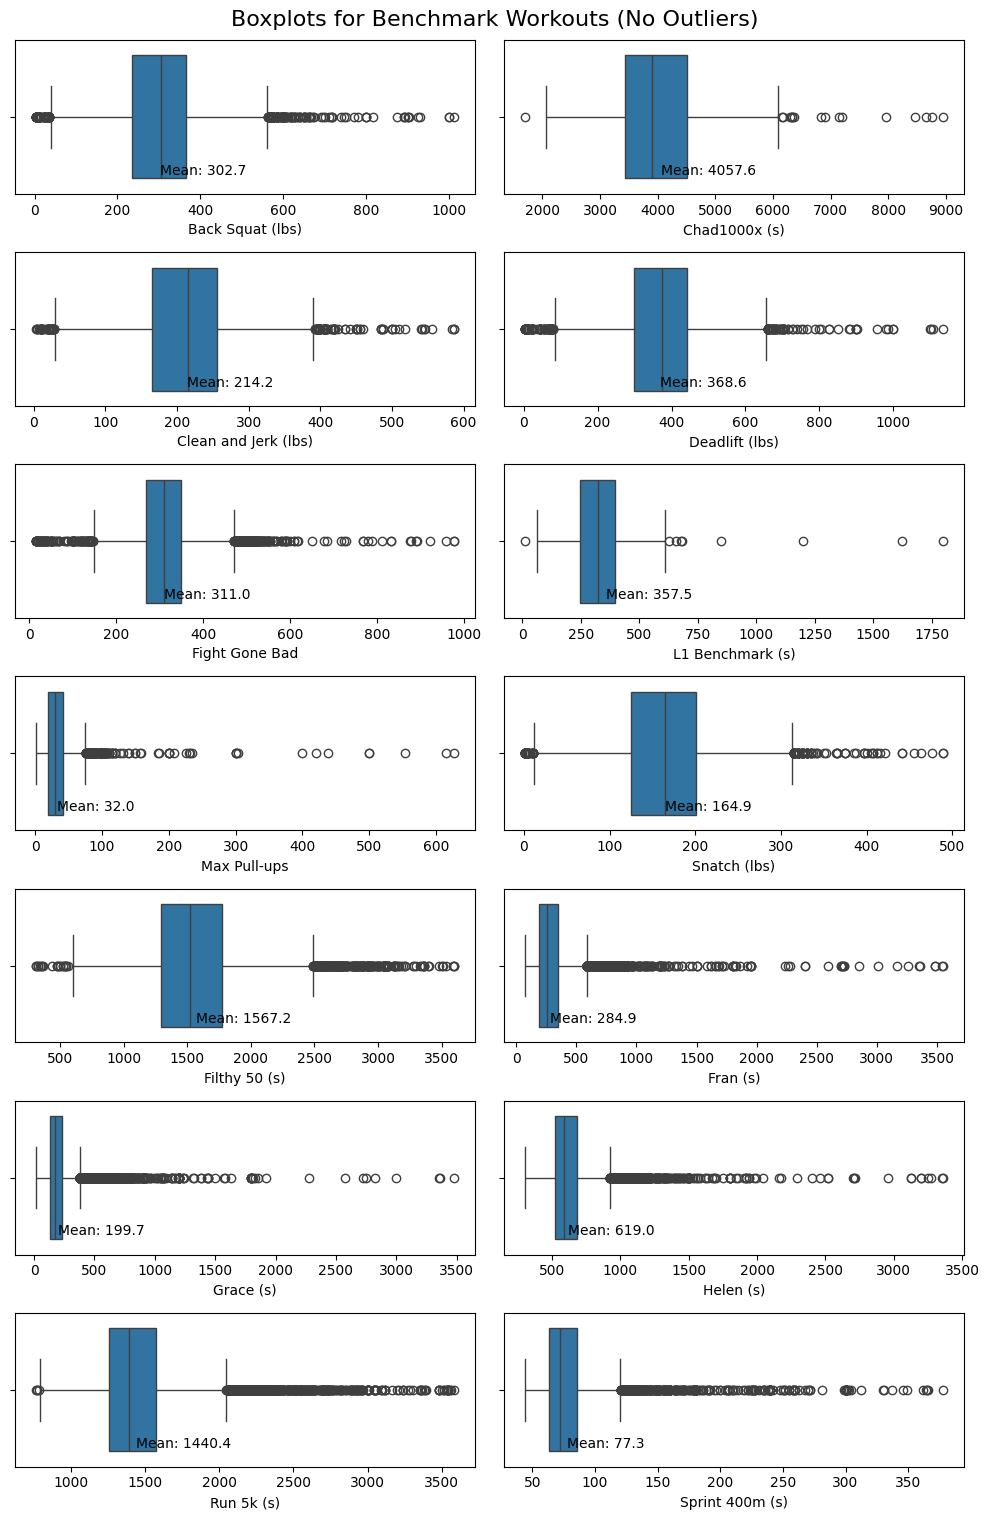

In [41]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(10, 15))

axes = axes.flatten()

summary_stats = pd.DataFrame(columns=['Workout', 'Mean', 'Median','Min', '25%', '50%', '75%', 'Max'])

for i, column in enumerate(benchmark_workouts):
    df_no_outliers_iqr[column] = pd.to_numeric(df_no_outliers_iqr[column], errors='coerce')
    df_no_outliers_iqr[column].dropna(inplace=True)
    
    sns.boxplot(x=df_no_outliers_iqr[column], ax=axes[i], orient='horizontal') 
#     axes[i].set_title(column)

    mean_value = round(df_no_outliers_iqr[column].mean(),1)
    axes[i].text(mean_value, 0.35, f'Mean: {mean_value}', color='black', verticalalignment='center')
    
    mean_value = df_no_outliers_iqr[column].mean()
    median_value = df_no_outliers_iqr[column].median()
    q25 = df_no_outliers_iqr[column].quantile(0.25)
    q50 = df_no_outliers_iqr[column].quantile(0.50)
    q75 = df_no_outliers_iqr[column].quantile(0.75)
    min_value = df_no_outliers_iqr[column].min()
    max_value = df_no_outliers_iqr[column].max()
    
    summary_stats = pd.concat([summary_stats, 
                            pd.DataFrame({'Workout': [column], 
                                          'Mean': [mean_value],
                                          'Median': [median_value],
                                          'Min': [min_value],
                                          '25%': [q25], 
                                          '50%': [q50], 
                                          '75%': [q75],
                                          'Max': [max_value]})])
plt.tight_layout()

fig.suptitle('Boxplots for Benchmark Workouts (No Outliers)', y=1.01, fontsize=16)
fig.savefig('reports/figures/boxplots_benchmark_workouts_no_outliers.png')

plt.show()

In [43]:
summary_stats

,Workout,Mean,Median,Min,25%,50%,75%,Max
0,Back Squat (lbs),302.708825,305.0000,3.0,235.0000,305.0000,365.00000,1012.00000
0,Chad1000x (s),4057.609259,3896.5000,1695.0,3430.7500,3896.5000,4516.75000,8956.00000
0,Clean and Jerk (lbs),214.150829,215.0000,3.0,165.3465,215.0000,255.73592,587.00000
0,Deadlift (lbs),368.598658,374.7854,3.0,297.6237,374.7854,440.92400,1135.37930
0,Fight Gone Bad,310.990179,309.0000,15.0,269.0000,309.0000,350.00000,978.00000
0,L1 Benchmark (s),357.516779,321.0000,10.0,245.0000,321.0000,395.00000,1800.00000
0,Max Pull-ups,31.997981,30.0000,1.0,20.0000,30.0000,42.00000,627.00000
0,Snatch (lbs),164.938205,165.0000,1.0,125.0000,165.0000,200.62042,489.42564
0,Filthy 50 (s),1567.226876,1519.0000,310.0,1298.0000,1519.0000,1774.00000,3599.00000
0,Fran (s),284.894531,254.0000,72.0,186.0000,254.0000,346.00000,3552.00000


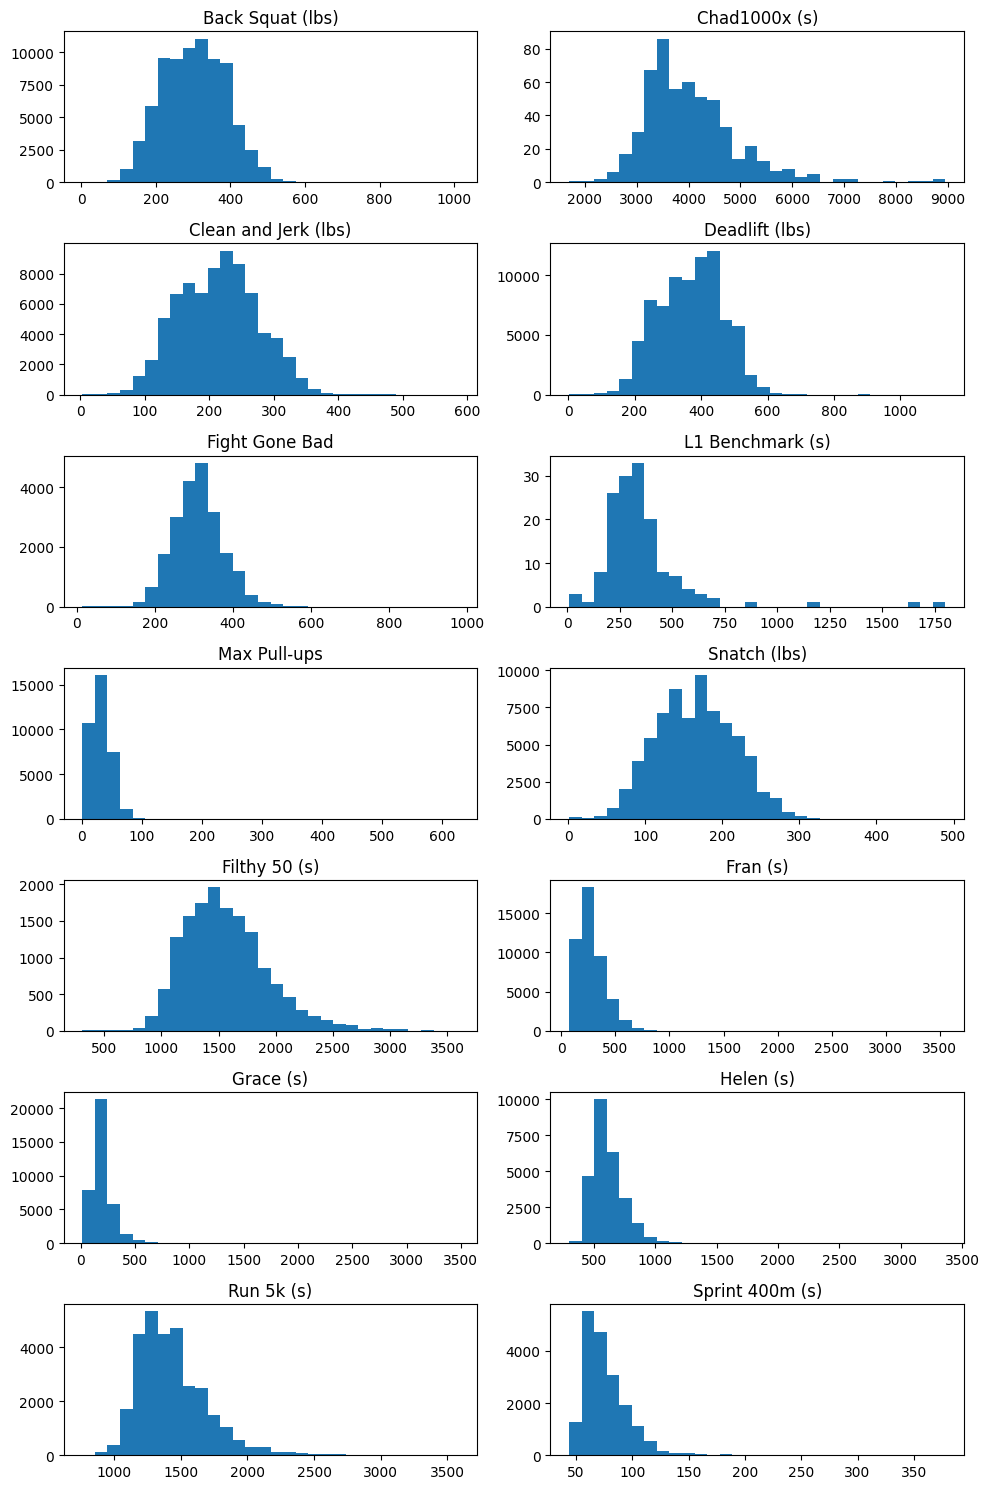

In [44]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(10, 15))

axes = axes.flatten()

for i, column in enumerate(benchmark_workouts):
    axes[i].hist(df[column], bins=30) #, color='blue', edgecolor='black') 
    axes[i].set_title(column)

plt.tight_layout()

fig.savefig('reports/figures/histogram.png')

plt.show()

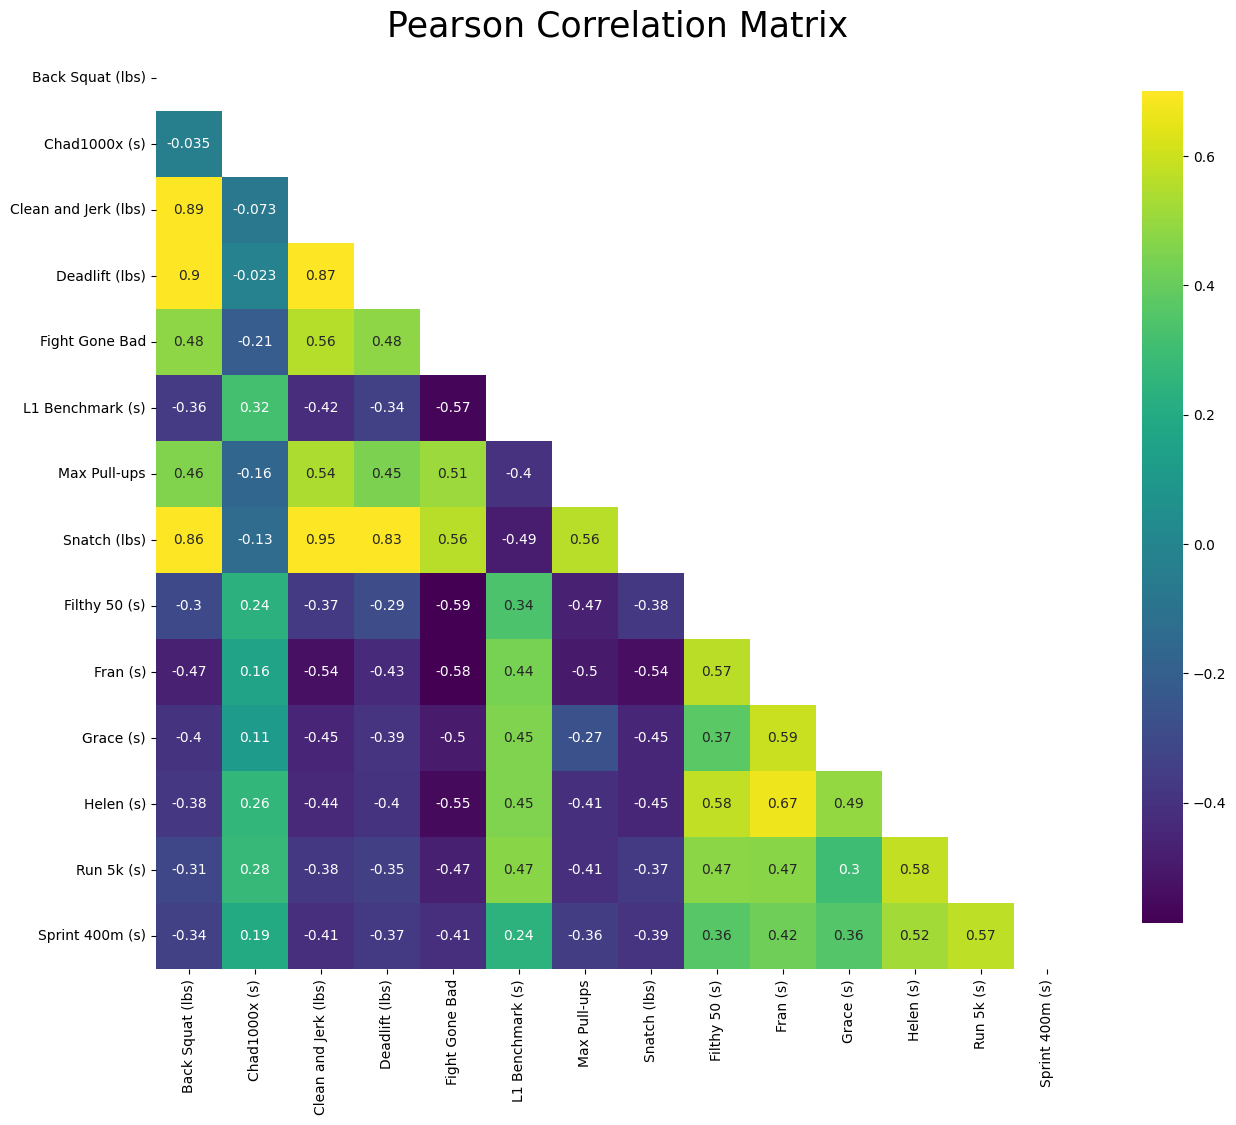

In [45]:
mask = np.zeros_like(df[benchmark_workouts].corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix', fontsize=25)

sns.heatmap(df[benchmark_workouts].corr(), vmax=0.7, square=True, cmap="viridis", 
            linecolor='w', mask=mask, annot=True, cbar_kws={"shrink": .9});

plt.savefig('reports/figures/pearson_corr_matrix.png')

In [48]:
corr_matrix = df[benchmark_workouts].corr().astype(float)
corr_matrix.T

,Back Squat (lbs),Chad1000x (s),Clean and Jerk (lbs),Deadlift (lbs),Fight Gone Bad,L1 Benchmark (s),Max Pull-ups,Snatch (lbs),Filthy 50 (s),Fran (s),Grace (s),Helen (s),Run 5k (s),Sprint 400m (s)
Back Squat (lbs),1.000000,-0.035211,0.892390,0.900687,0.481445,-0.360916,0.458491,0.862141,-0.302139,-0.468206,-0.396868,-0.382842,-0.311072,-0.339768
Chad1000x (s),-0.035211,1.000000,-0.073365,-0.022613,-0.213732,0.315304,-0.161971,-0.134740,0.235727,0.157863,0.114595,0.260781,0.277636,0.193708
Clean and Jerk (lbs),0.892390,-0.073365,1.000000,0.870391,0.556083,-0.424733,0.539484,0.948662,-0.368592,-0.535704,-0.453674,-0.444938,-0.379443,-0.411605
Deadlift (lbs),0.900687,-0.022613,0.870391,1.000000,0.482366,-0.338654,0.447649,0.833908,-0.290989,-0.430362,-0.391419,-0.398513,-0.349221,-0.372422
Fight Gone Bad,0.481445,-0.213732,0.556083,0.482366,1.000000,-0.565977,0.506915,0.563212,-0.585943,-0.581706,-0.495001,-0.553597,-0.471749,-0.414275
L1 Benchmark (s),-0.360916,0.315304,-0.424733,-0.338654,-0.565977,1.000000,-0.404788,-0.485726,0.335365,0.438074,0.451059,0.450258,0.469576,0.238682
Max Pull-ups,0.458491,-0.161971,0.539484,0.447649,0.506915,-0.404788,1.000000,0.563804,-0.465391,-0.500466,-0.266198,-0.410035,-0.413134,-0.359299
Snatch (lbs),0.862141,-0.134740,0.948662,0.833908,0.563212,-0.485726,0.563804,1.000000,-0.375225,-0.535715,-0.445808,-0.445435,-0.372544,-0.390702
Filthy 50 (s),-0.302139,0.235727,-0.368592,-0.290989,-0.585943,0.335365,-0.465391,-0.375225,1.000000,0.565520,0.370749,0.577560,0.474360,0.358853
Fran (s),-0.468206,0.157863,-0.535704,-0.430362,-0.581706,0.438074,-0.500466,-0.535715,0.565520,1.000000,0.592256,0.669811,0.470115,0.415757


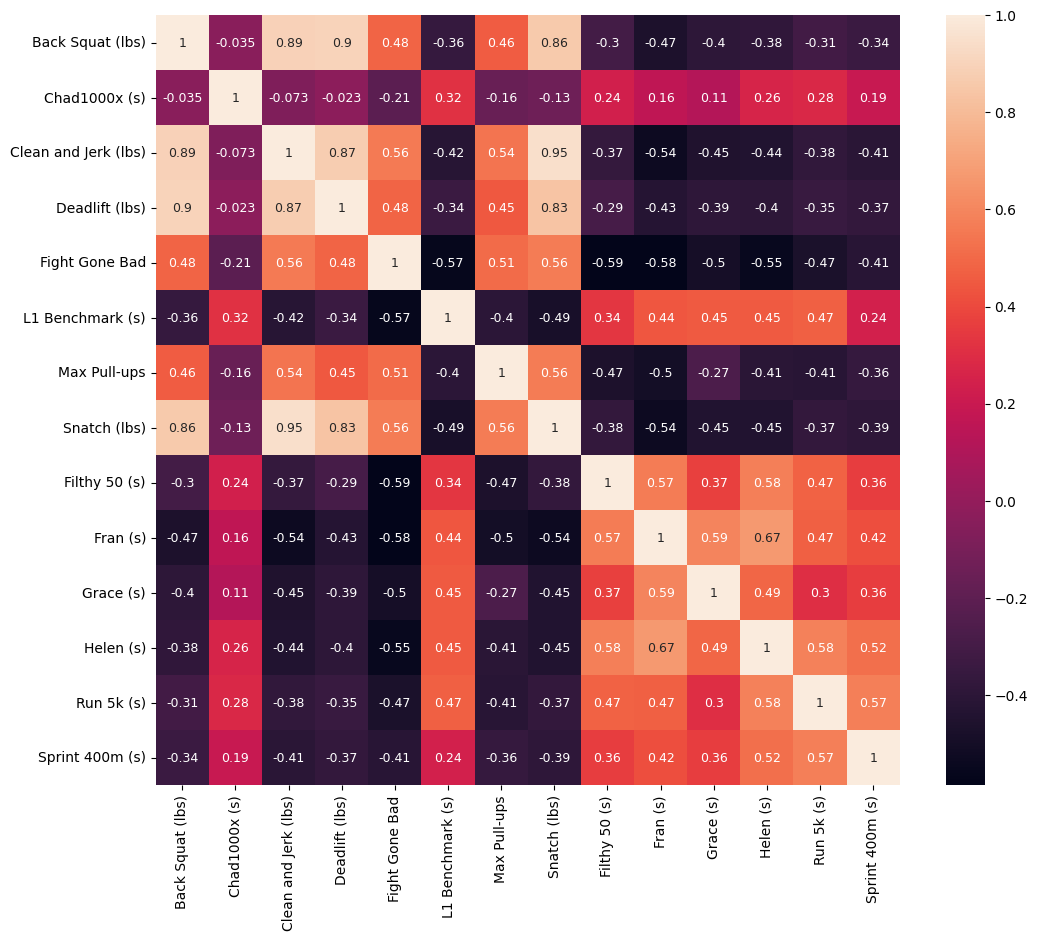

In [49]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 9})
plt.savefig('reports/figures/corr_heatmap.png')
plt.show()

In [97]:
df['Division'].unique()

array(['Boys (14-15)', 'Boys (16-17)', 'Men', 'Men (55-59)',
       'Men (60-64)', 'Men Upper Extremity', 'Women', 'Women (55-59)',
       'Men (65+)', 'Men Vision', 'Men (60+)', 'Women (60+)',
       'Girls (16-17)', 'Women (45-49)', 'Girls (14-15)', 'Men (45-49)',
       'Men (50-54)', 'Women (50-54)', 'Men Lower Extremity',
       'Men Multi-Extremity', 'Men Seated (w/o hip)', 'Men Short Stature',
       'Women (60-64)', 'Women (65+)', 'Women Multi-Extremity',
       'Women Upper Extremity', 'Men Seated (w/ hip)',
       'Women Lower Extremity', 'Women Short Stature', 'Men (35-39)',
       'Men (40-44)', 'Women (35-39)', 'Women (40-44)', nan], dtype=object)

In [98]:
df_ = df[~df['Rank'].isna()]

In [99]:
df_['Qualifier'].unique()

array(['quarterfinals', 'open', 'semifinals', 'games'], dtype=object)

In [100]:
df_['Games_Level'].unique()

array(['Africa', 'Asia', 'Europe', 'North America East',
       'North America West', 'Oceania', 'South America', 'worldwide'],
      dtype=object)

In [101]:
df_['Division'].unique()

array(['Men', 'Women', 'Boys (14-15)', 'Boys (16-17)', 'Girls (16-17)',
       'Men (35-39)', 'Men (40-44)', 'Men (45-49)', 'Men (50-54)',
       'Men (55-59)', 'Men (60-64)', 'Men (65+)', 'Men Lower Extremity',
       'Men Multi-Extremity', 'Men Seated (w/ hip)',
       'Men Seated (w/o hip)', 'Men Short Stature', 'Men Upper Extremity',
       'Men Vision', 'Women (35-39)', 'Women (40-44)', 'Women (45-49)',
       'Women (50-54)', 'Women (55-59)', 'Women (60-64)', 'Women (65+)',
       'Women Lower Extremity', 'Women Multi-Extremity',
       'Women Short Stature', 'Women Upper Extremity'], dtype=object)

In [102]:
divisions_list = ['Men', 'Women', 'Boys (14-15)', 'Boys (16-17)', 'Girls (16-17)',
       'Men (35-39)', 'Men (40-44)', 'Men (45-49)', 'Men (50-54)',
       'Men (55-59)', 'Men (60-64)', 'Men (65+)', 'Men Lower Extremity',
       'Men Multi-Extremity', 'Men Seated (w/ hip)',
       'Men Seated (w/o hip)', 'Men Short Stature', 'Men Upper Extremity',
       'Men Vision', 'Women (35-39)', 'Women (40-44)', 'Women (45-49)',
       'Women (50-54)', 'Women (55-59)', 'Women (60-64)', 'Women (65+)',
       'Women Lower Extremity', 'Women Multi-Extremity',
       'Women Short Stature', 'Women Upper Extremity']

In [103]:
df_.loc[df_['Division'] == 'Boys (14-15)', :].describe()

,Country,Rank,Year,Back Squat (lbs),Clean and Jerk (lbs),Deadlift (lbs),Snatch (lbs),Fight Gone Bad,Max Pull-ups,Chad1000x (s),L1 Benchmark (s),Filthy 50 (s),Fran (s),Grace (s),Helen (s),Run 5k (s),Sprint 400m (s)
count,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
mean,NaN,1172.0,2023.0,116.0,59.0,155.0,47.0,NaN,11.0,2987.0,NaN,NaN,NaN,NaN,581.0,1591.0,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1172.0,2023.0,116.0,59.0,155.0,47.0,NaN,11.0,2987.0,NaN,NaN,NaN,NaN,581.0,1591.0,NaN
25%,NaN,1172.0,2023.0,116.0,59.0,155.0,47.0,NaN,11.0,2987.0,NaN,NaN,NaN,NaN,581.0,1591.0,NaN
50%,NaN,1172.0,2023.0,116.0,59.0,155.0,47.0,NaN,11.0,2987.0,NaN,NaN,NaN,NaN,581.0,1591.0,NaN
75%,NaN,1172.0,2023.0,116.0,59.0,155.0,47.0,NaN,11.0,2987.0,NaN,NaN,NaN,NaN,581.0,1591.0,NaN
max,NaN,1172.0,2023.0,116.0,59.0,155.0,47.0,NaN,11.0,2987.0,NaN,NaN,NaN,NaN,581.0,1591.0,NaN


In [43]:
def boxplots(dataframe, division):
    dataframe = dataframe.loc[dataframe['Division'] == division, :].copy() 

    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(10, 15))
    axes = axes.flatten()

    summary_stats = pd.DataFrame(columns=['Workout', 'Mean', 'Median', 'Min', '25%', '50%', '75%', 'Max'])

    for i, column in enumerate(benchmark_workouts):
        df.loc[df['Division'] == division, column] = pd.to_numeric(df.loc[df['Division'] == division, column], 
                                                                   errors='coerce')

        dataframe[column].dropna(inplace=True)

        sns.boxplot(x=dataframe[column], ax=axes[i], orient='horizontal')
        # axes[i].set_title(column)

        mean_value = round(dataframe[column].mean(),1)
        axes[i].text(mean_value, 0.35, f'Mean: {mean_value}', color='black', verticalalignment='center')

        mean_value = dataframe[column].mean()
        median_value = dataframe[column].median()
        q25 = dataframe[column].quantile(0.25)
        q50 = dataframe[column].quantile(0.50)
        q75 = dataframe[column].quantile(0.75)
        min_value = dataframe[column].min()
        max_value = dataframe[column].max()

        summary_stats = pd.concat([summary_stats, 
                                pd.DataFrame({'Workout': [column], 
                                              'Mean': [mean_value],
                                              'Median': [median_value],
                                              'Min': [min_value],
                                              '25%': [q25], 
                                              '50%': [q50], 
                                              '75%': [q75],
                                              'Max': [max_value]})])
    plt.tight_layout()

    fig.suptitle(f"Boxplots for {division}'s Division", y=1.01, fontsize=16)
    plt.savefig(f"reports/figures/boxplot_{division}.png", bbox_inches='tight')
    summary_stats = summary_stats.round(2)
    summary_stats.T.to_csv(f"reports/stats_{division}.csv")

    plt.show()
    
    print(summary_stats.to_string(index=False))

In [44]:
def print_boxplots_by_division(df):    
    for division in divisions_list:
        boxplots(df, division)

C:\Users\eunic\AppData\Local\Temp\ipykernel_31404\2413622702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats = pd.concat([summary_stats,


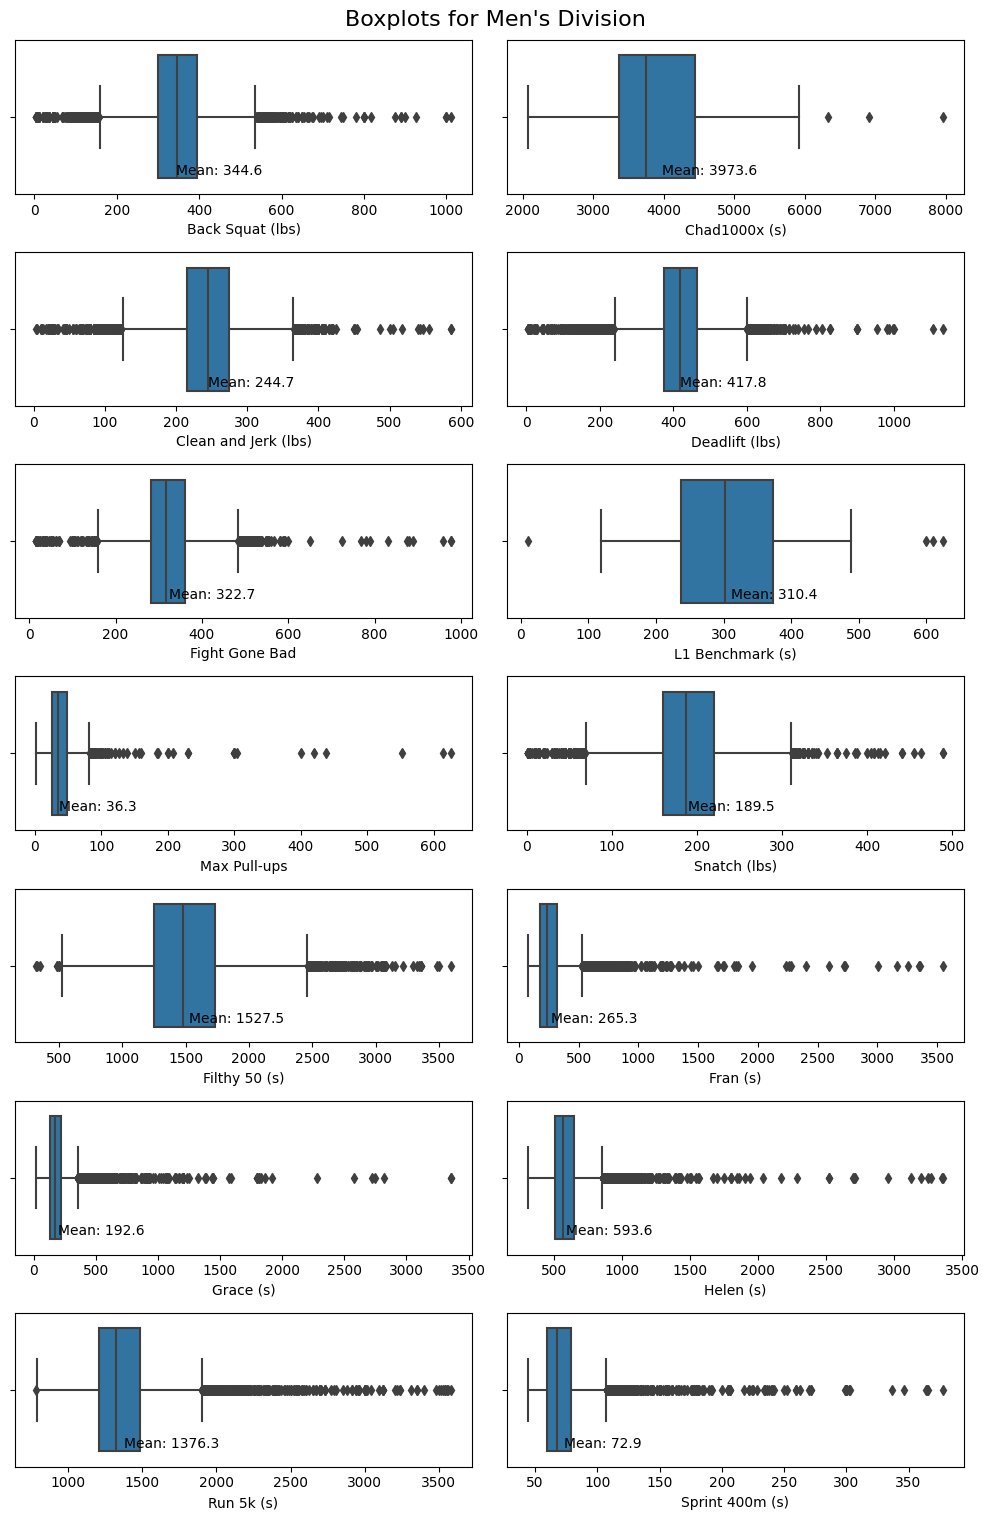

             Workout    Mean  Median    Min     25%     50%     75%     Max
    Back Squat (lbs)  344.57  345.00    3.0  300.00  345.00  395.00 1012.00
       Chad1000x (s) 3973.55 3743.00 2068.0 3360.00 3743.00 4438.00 7968.00
Clean and Jerk (lbs)  244.69  245.00    3.0  215.00  245.00  275.00  587.00
      Deadlift (lbs)  417.83  418.88    3.0  374.79  418.88  465.00 1135.38
      Fight Gone Bad  322.72  318.00   15.0  281.00  318.00  362.00  978.00
    L1 Benchmark (s)  310.41  301.50   10.0  236.25  301.50  372.75  625.00
        Max Pull-ups   36.29   35.00    1.0   25.00   35.00   48.00  627.00
        Snatch (lbs)  189.50  187.39    1.0  160.00  187.39  220.46  489.43
       Filthy 50 (s) 1527.54 1476.00  315.0 1251.00 1476.00 1735.00 3599.00
            Fran (s)  265.27  233.00   72.0  175.00  233.00  317.00 3552.00
           Grace (s)  192.65  167.00   14.0  130.00  167.00  221.00 3362.00
           Helen (s)  593.61  565.00  308.0  506.00  565.00  647.00 3363.00
          Ru

C:\Users\eunic\AppData\Local\Temp\ipykernel_31404\2413622702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats = pd.concat([summary_stats,


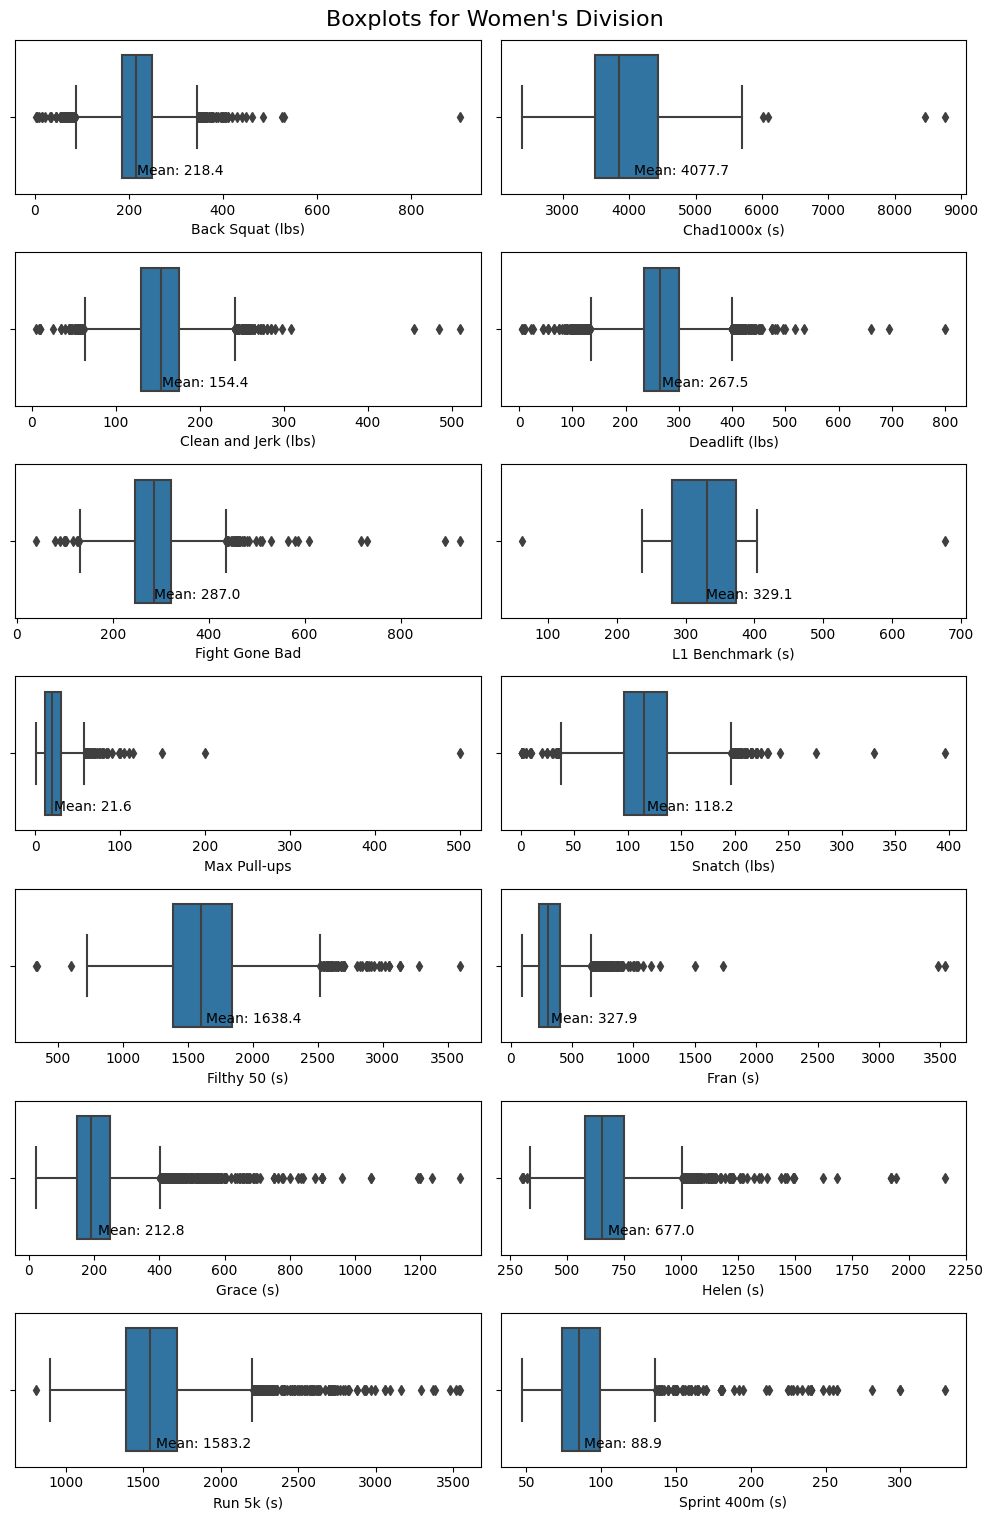

             Workout    Mean  Median    Min     25%     50%     75%     Max
    Back Squat (lbs)  218.42  216.00    3.0  185.00  216.00  250.00  903.00
       Chad1000x (s) 4077.71 3842.00 2382.0 3486.75 3842.00 4438.25 8760.00
Clean and Jerk (lbs)  154.40  154.32    5.0  130.00  154.32  175.00  509.27
      Deadlift (lbs)  267.53  265.00    5.0  233.69  265.00  300.00  800.00
      Fight Gone Bad  287.04  287.00   40.0  246.00  287.00  322.00  923.00
    L1 Benchmark (s)  329.06  331.00   62.0  280.00  331.00  373.00  677.00
        Max Pull-ups   21.61   20.00    1.0   11.00   20.00   30.00  500.00
        Snatch (lbs)  118.16  115.00    1.0   97.00  115.00  136.69  396.83
       Filthy 50 (s) 1638.40 1600.00  330.0 1381.50 1600.00 1836.00 3591.00
            Fran (s)  327.89  303.00   91.0  231.00  303.00  400.00 3540.00
           Grace (s)  212.78  189.00   22.0  149.00  189.00  250.00 1320.00
           Helen (s)  676.96  651.00  300.0  579.00  651.00  749.00 2160.00
          Ru

C:\Users\eunic\AppData\Local\Temp\ipykernel_31404\2413622702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats = pd.concat([summary_stats,
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


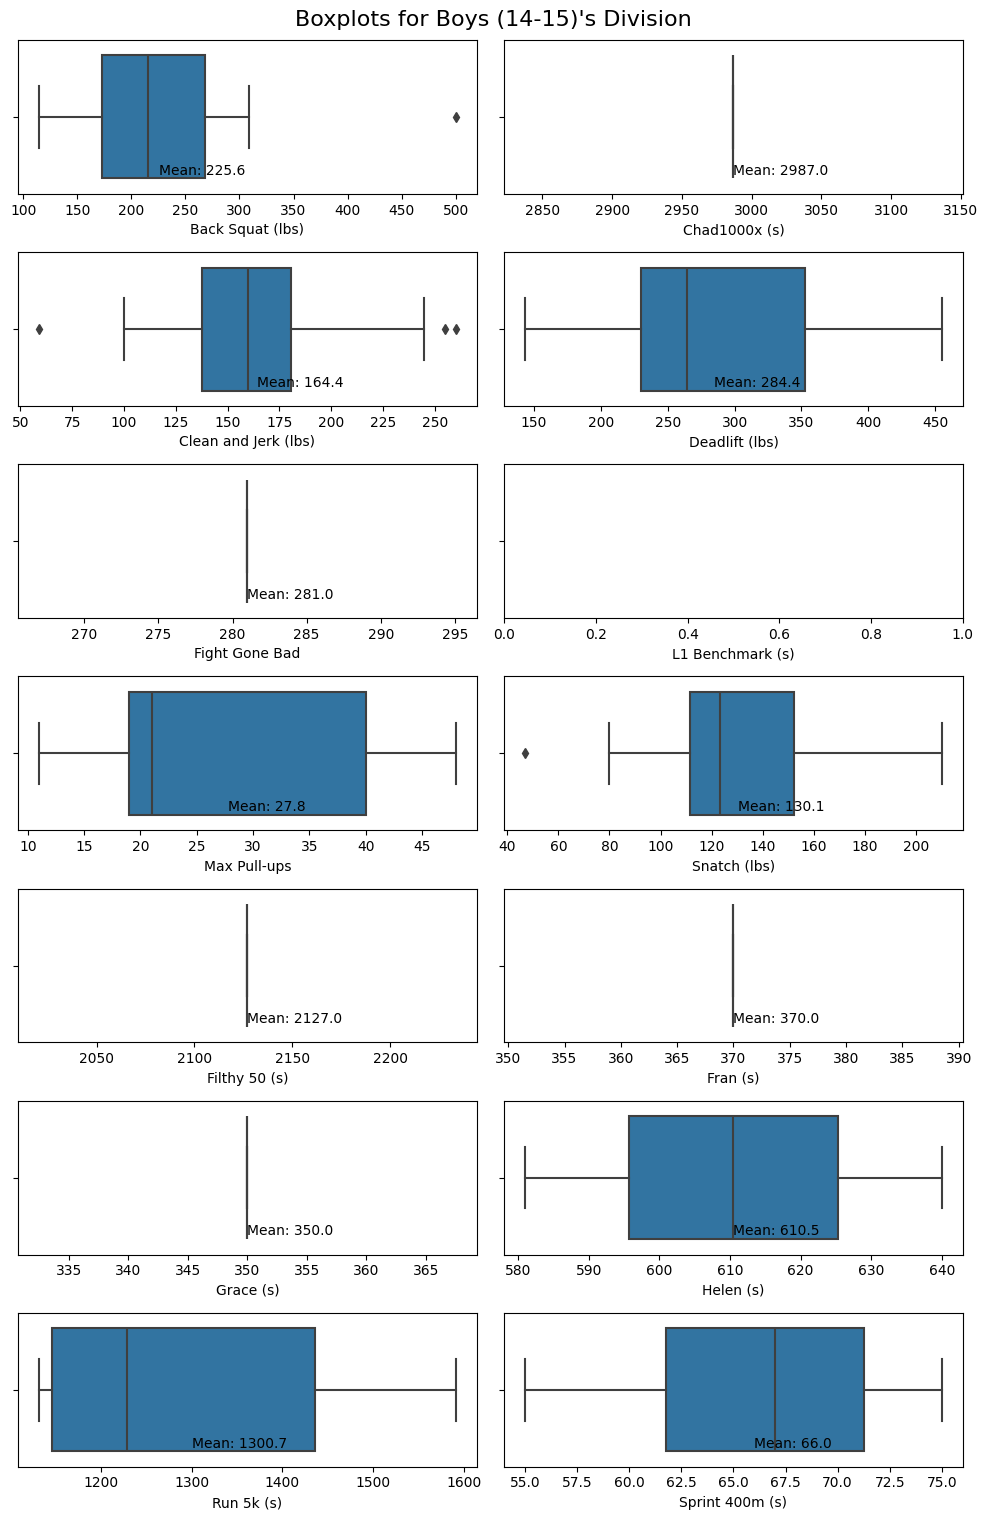

             Workout    Mean  Median     Min     25%     50%     75%     Max
    Back Squat (lbs)  225.56  215.00  114.64  172.67  215.00  268.50  500.00
       Chad1000x (s) 2987.00 2987.00 2987.00 2987.00 2987.00 2987.00 2987.00
Clean and Jerk (lbs)  164.36  160.00   59.00  137.79  160.00  180.68  260.15
      Deadlift (lbs)  284.37  264.55  143.30  230.00  264.55  352.74  455.00
      Fight Gone Bad  281.00  281.00  281.00  281.00  281.00  281.00  281.00
    L1 Benchmark (s)     NaN     NaN     NaN     NaN     NaN     NaN     NaN
        Max Pull-ups   27.80   21.00   11.00   19.00   21.00   40.00   48.00
        Snatch (lbs)  130.13  123.13   47.00  111.42  123.13  152.08  210.00
       Filthy 50 (s) 2127.00 2127.00 2127.00 2127.00 2127.00 2127.00 2127.00
            Fran (s)  370.00  370.00  370.00  370.00  370.00  370.00  370.00
           Grace (s)  350.00  350.00  350.00  350.00  350.00  350.00  350.00
           Helen (s)  610.50  610.50  581.00  595.75  610.50  625.25  640.00

C:\Users\eunic\AppData\Local\Temp\ipykernel_31404\2413622702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats = pd.concat([summary_stats,
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be 

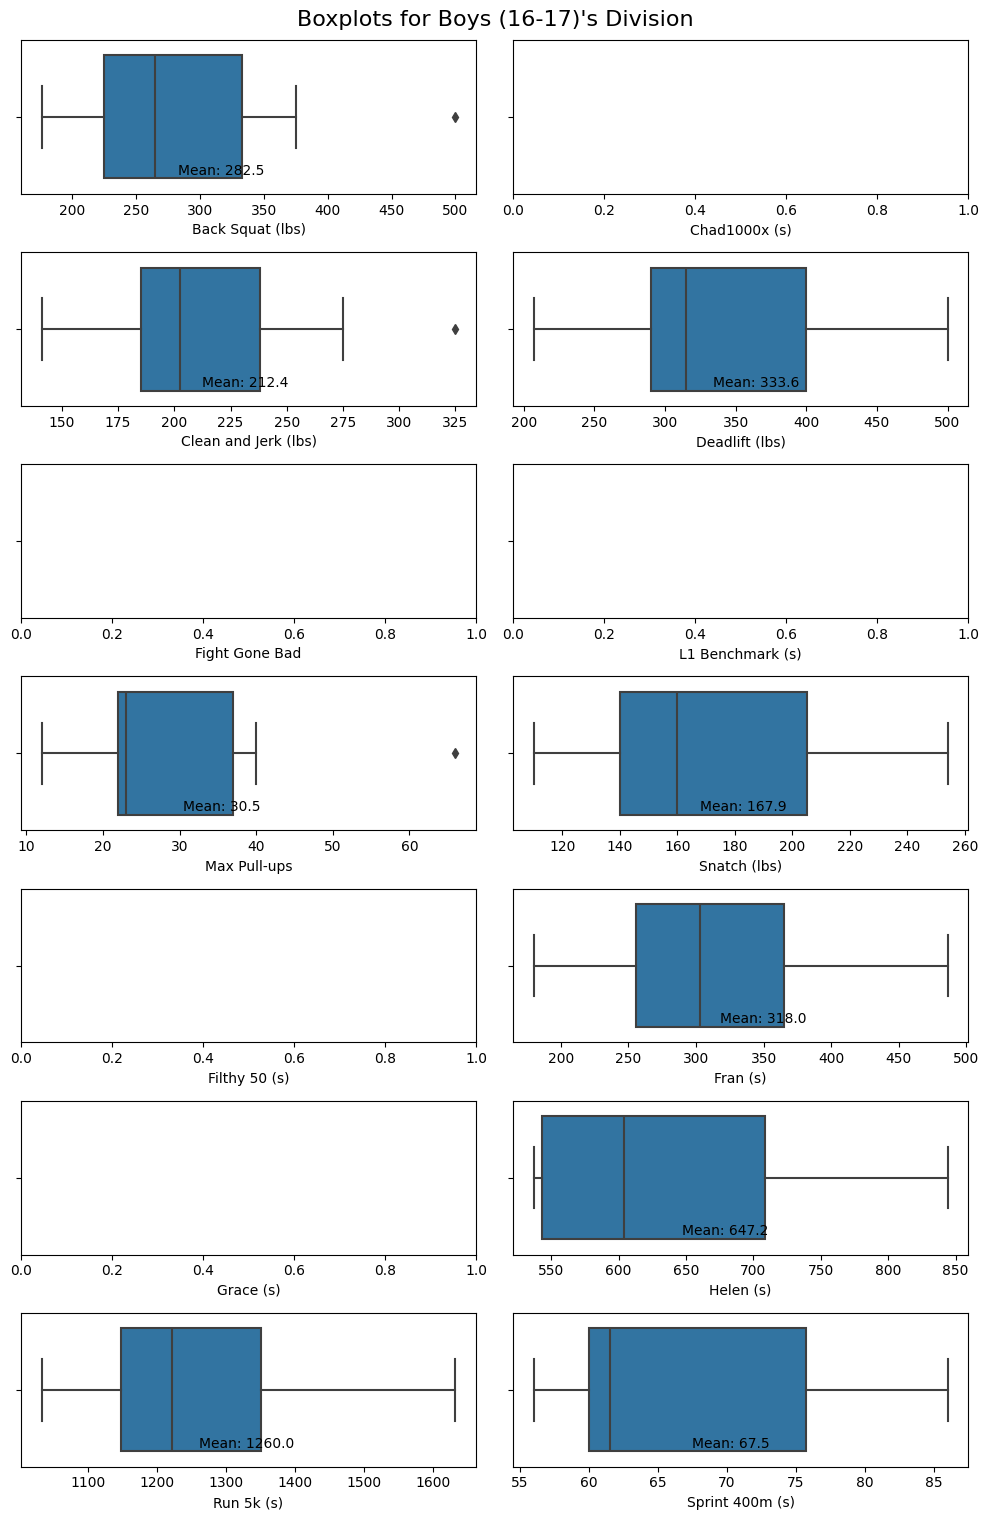

             Workout    Mean  Median    Min     25%    50%     75%    Max
    Back Squat (lbs)  282.53   265.0  176.0  225.00  265.0  332.85  500.0
       Chad1000x (s)     NaN     NaN    NaN     NaN    NaN     NaN    NaN
Clean and Jerk (lbs)  212.44   202.5  141.0  185.00  202.5  238.13  325.0
      Deadlift (lbs)  333.63   315.0  207.0  290.00  315.0  400.00  500.0
      Fight Gone Bad     NaN     NaN    NaN     NaN    NaN     NaN    NaN
    L1 Benchmark (s)     NaN     NaN    NaN     NaN    NaN     NaN    NaN
        Max Pull-ups   30.45    23.0   12.0   22.00   23.0   37.00   66.0
        Snatch (lbs)  167.88   160.0  110.0  140.00  160.0  205.00  254.0
       Filthy 50 (s)     NaN     NaN    NaN     NaN    NaN     NaN    NaN
            Fran (s)  318.00   303.0  180.0  255.75  303.0  365.25  486.0
           Grace (s)     NaN     NaN    NaN     NaN    NaN     NaN    NaN
           Helen (s)  647.25   604.0  537.0  543.00  604.0  708.25  844.0
          Run 5k (s) 1260.00  1222.0 1

C:\Users\eunic\AppData\Local\Temp\ipykernel_31404\2413622702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats = pd.concat([summary_stats,
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be 

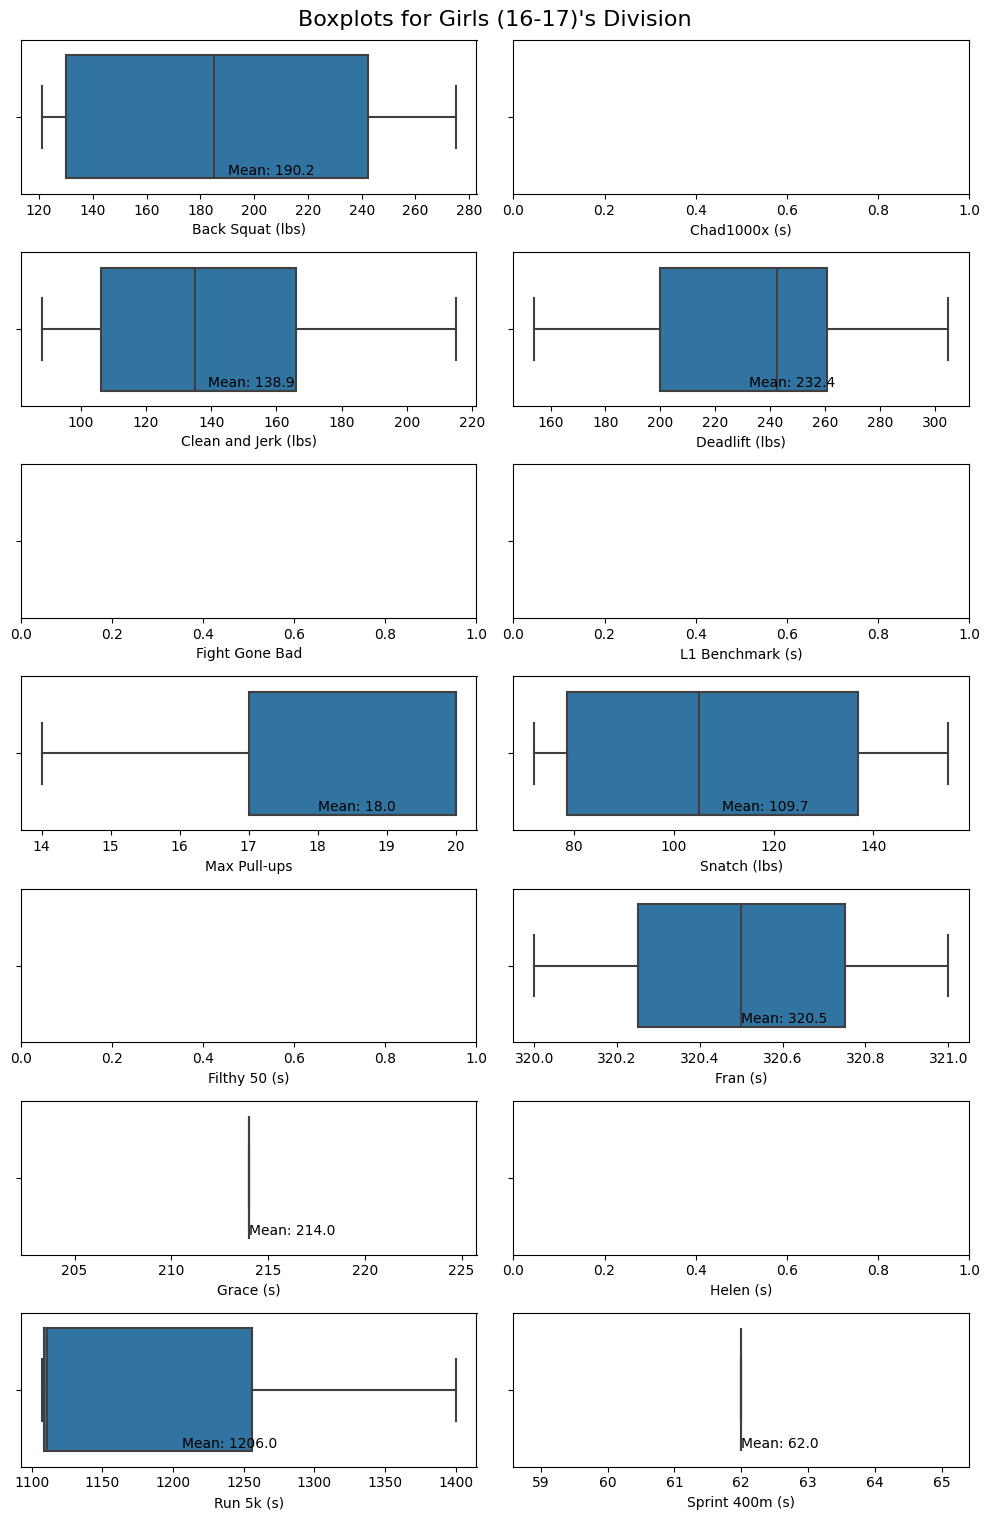

             Workout    Mean  Median    Min     25%    50%     75%    Max
    Back Squat (lbs)  190.25   185.0  121.0  130.00  185.0  242.51  275.0
       Chad1000x (s)     NaN     NaN    NaN     NaN    NaN     NaN    NaN
Clean and Jerk (lbs)  138.88   135.0   88.0  106.25  135.0  166.07  215.0
      Deadlift (lbs)  232.39   242.5  154.0  200.00  242.5  260.63  305.0
      Fight Gone Bad     NaN     NaN    NaN     NaN    NaN     NaN    NaN
    L1 Benchmark (s)     NaN     NaN    NaN     NaN    NaN     NaN    NaN
        Max Pull-ups   18.00    20.0   14.0   17.00   20.0   20.00   20.0
        Snatch (lbs)  109.65   105.0   72.0   78.50  105.0  136.95  155.0
       Filthy 50 (s)     NaN     NaN    NaN     NaN    NaN     NaN    NaN
            Fran (s)  320.50   320.5  320.0  320.25  320.5  320.75  321.0
           Grace (s)  214.00   214.0  214.0  214.00  214.0  214.00  214.0
           Helen (s)     NaN     NaN    NaN     NaN    NaN     NaN    NaN
          Run 5k (s) 1206.00  1111.0 1

C:\Users\eunic\AppData\Local\Temp\ipykernel_31404\2413622702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats = pd.concat([summary_stats,


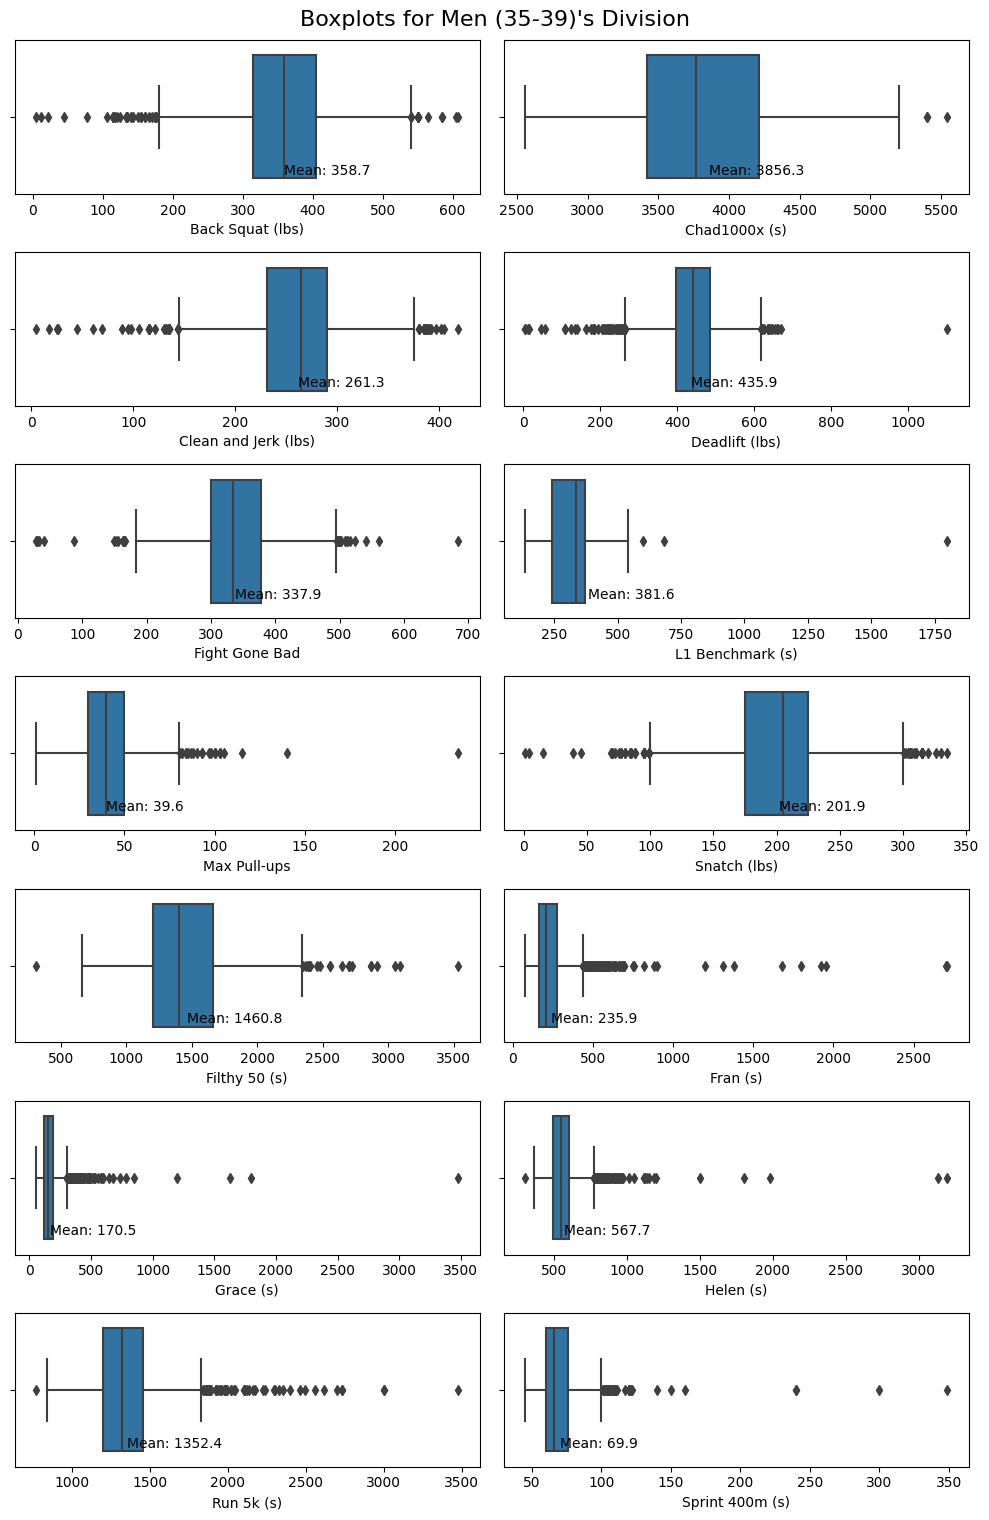

             Workout    Mean  Median     Min     25%     50%     75%     Max
    Back Squat (lbs)  358.68  359.35    4.41  315.00  359.35  405.00  608.48
       Chad1000x (s) 3856.28 3768.00 2557.00 3422.00 3768.00 4210.00 5546.00
Clean and Jerk (lbs)  261.27  264.55    4.41  231.49  264.55  290.00  418.88
      Deadlift (lbs)  435.91  440.00    4.41  396.83  440.00  485.00 1102.31
      Fight Gone Bad  337.88  335.00   28.00  300.00  335.00  378.00  685.00
    L1 Benchmark (s)  381.59  335.00  135.00  241.00  335.00  370.00 1800.00
        Max Pull-ups   39.57   40.00    1.00   30.00   40.00   50.00  235.00
        Snatch (lbs)  201.88  205.00    1.00  175.00  205.00  225.00  335.10
       Filthy 50 (s) 1460.83 1400.00  310.00 1202.00 1400.00 1660.25 3537.00
            Fran (s)  235.95  206.00   76.00  163.00  206.00  273.00 2712.00
           Grace (s)  170.51  151.00   55.00  119.00  151.00  193.00 3480.00
           Helen (s)  567.72  545.00  300.00  493.00  545.00  605.00 3198.00

C:\Users\eunic\AppData\Local\Temp\ipykernel_31404\2413622702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats = pd.concat([summary_stats,


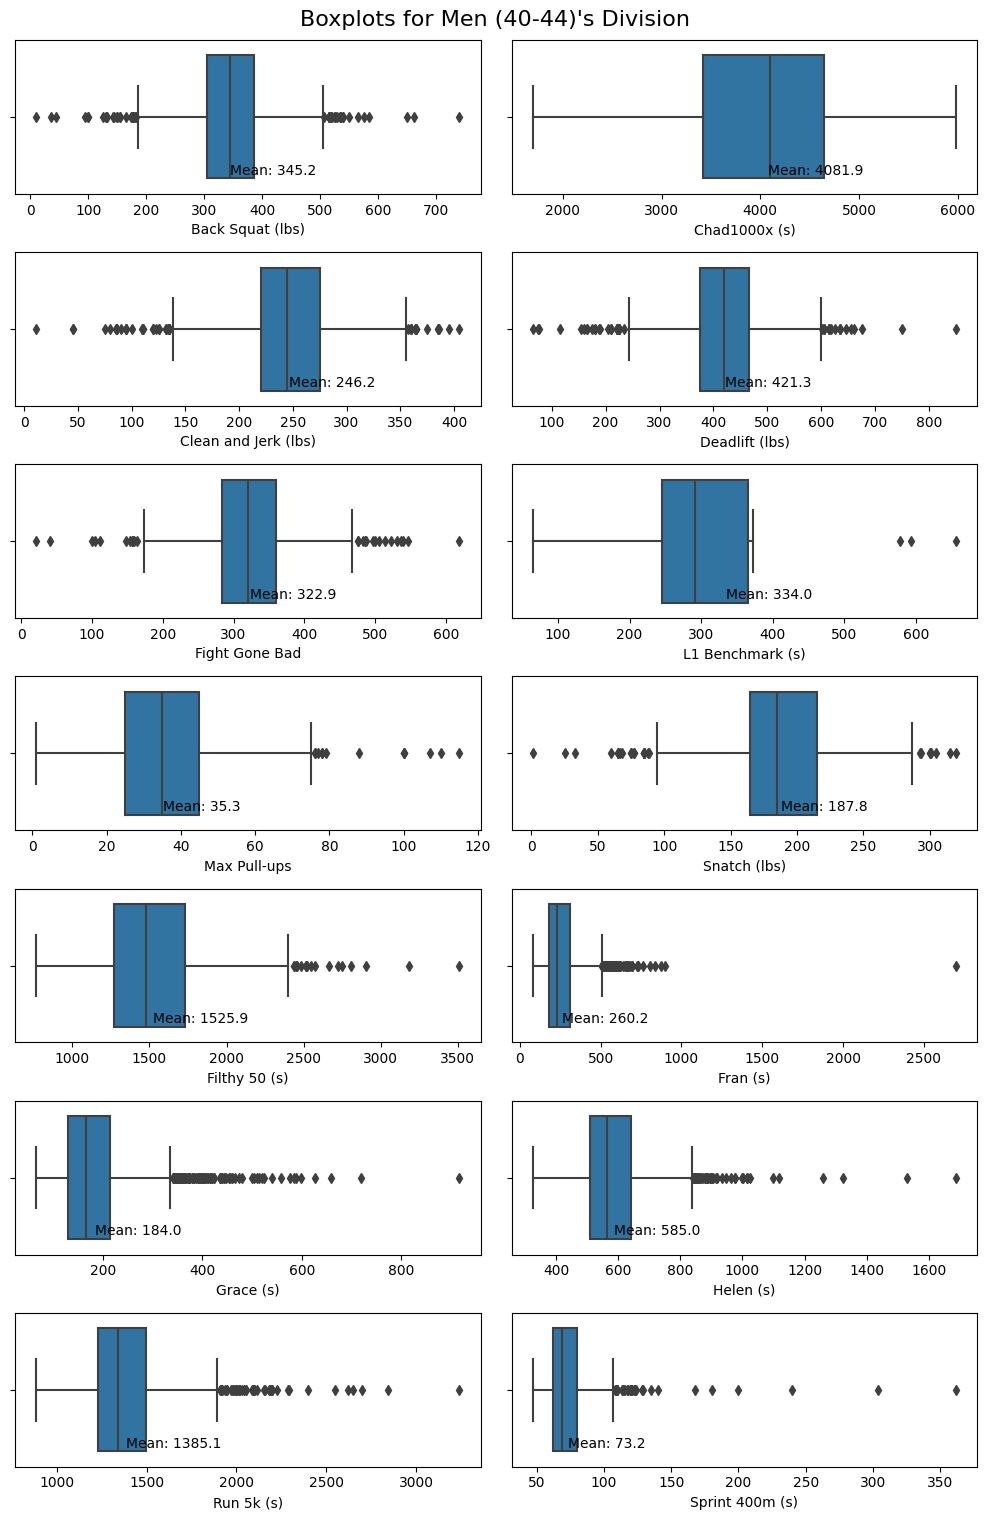

             Workout    Mean  Median     Min     25%     50%     75%    Max
    Back Squat (lbs)  345.18  345.00   10.00  305.00  345.00  385.81  740.0
       Chad1000x (s) 4081.92 4097.00 1695.00 3423.00 4097.00 4649.00 5985.0
Clean and Jerk (lbs)  246.21  245.00   11.02  220.46  245.00  275.00  405.0
      Deadlift (lbs)  421.31  418.88   65.00  375.00  418.88  465.00  850.0
      Fight Gone Bad  322.93  321.00   21.00  283.50  321.00  360.00  619.0
    L1 Benchmark (s)  334.00  291.00   65.00  245.00  291.00  365.50  656.0
        Max Pull-ups   35.26   35.00    1.00   25.00   35.00   45.00  115.0
        Snatch (lbs)  187.82  185.00    1.00  165.00  185.00  215.00  320.0
       Filthy 50 (s) 1525.92 1479.50  765.00 1268.25 1479.50 1729.00 3510.0
            Fran (s)  260.23  229.00   80.00  179.00  229.00  311.00 2700.0
           Grace (s)  183.98  165.00   65.00  130.25  165.00  214.00  917.0
           Helen (s)  585.01  564.00  325.00  508.00  564.00  640.00 1688.0
          Ru

C:\Users\eunic\AppData\Local\Temp\ipykernel_31404\2413622702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats = pd.concat([summary_stats,


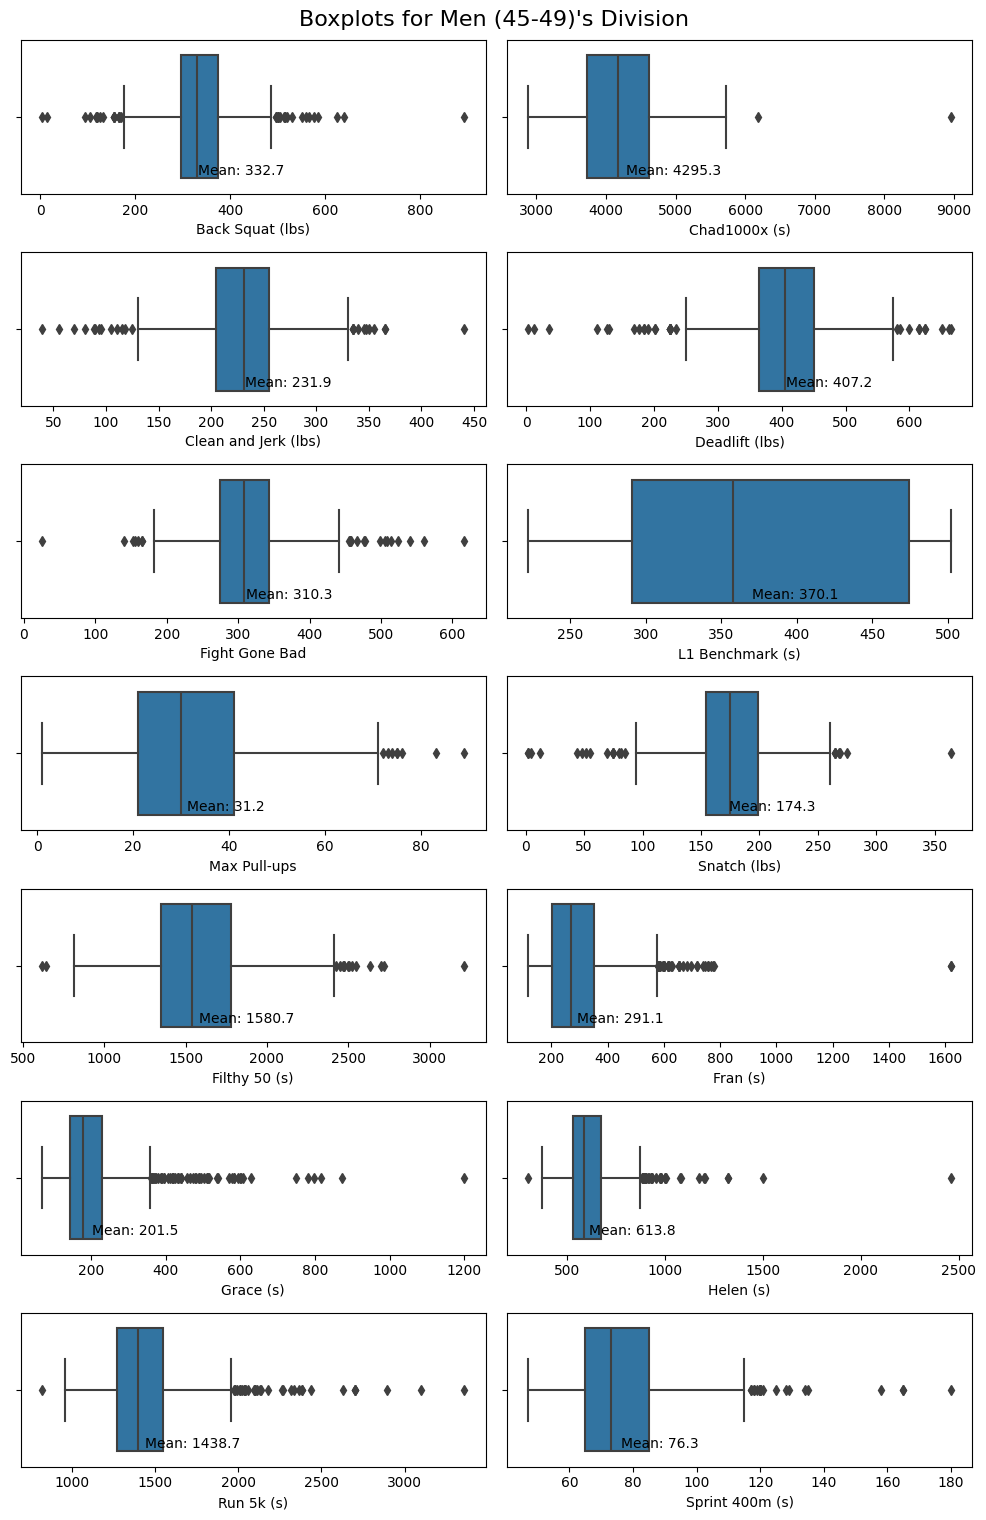

             Workout    Mean  Median    Min     25%     50%     75%     Max
    Back Squat (lbs)  332.66  330.69    3.0  295.00  330.69  374.79  892.87
       Chad1000x (s) 4295.31 4172.00 2883.0 3724.00 4172.00 4620.00 8956.00
Clean and Jerk (lbs)  231.85  231.49   39.0  205.00  231.49  255.00  440.92
      Deadlift (lbs)  407.16  405.00    3.0  365.00  405.00  450.00  665.00
      Fight Gone Bad  310.25  308.00   25.0  274.50  308.00  343.00  617.00
    L1 Benchmark (s)  370.12  357.50  222.0  290.50  357.50  474.00  502.00
        Max Pull-ups   31.25   30.00    1.0   21.00   30.00   41.00   89.00
        Snatch (lbs)  174.34  175.00    2.2  154.32  175.00  198.42  363.76
       Filthy 50 (s) 1580.71 1541.00  615.0 1350.00 1541.00 1777.00 3215.00
            Fran (s)  291.11  270.00  118.0  204.00  270.00  353.00 1620.00
           Grace (s)  201.47  178.00   68.0  144.50  178.00  230.50 1200.00
           Helen (s)  613.78  588.00  301.0  532.00  588.00  671.00 2460.00
          Ru

C:\Users\eunic\AppData\Local\Temp\ipykernel_31404\2413622702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats = pd.concat([summary_stats,


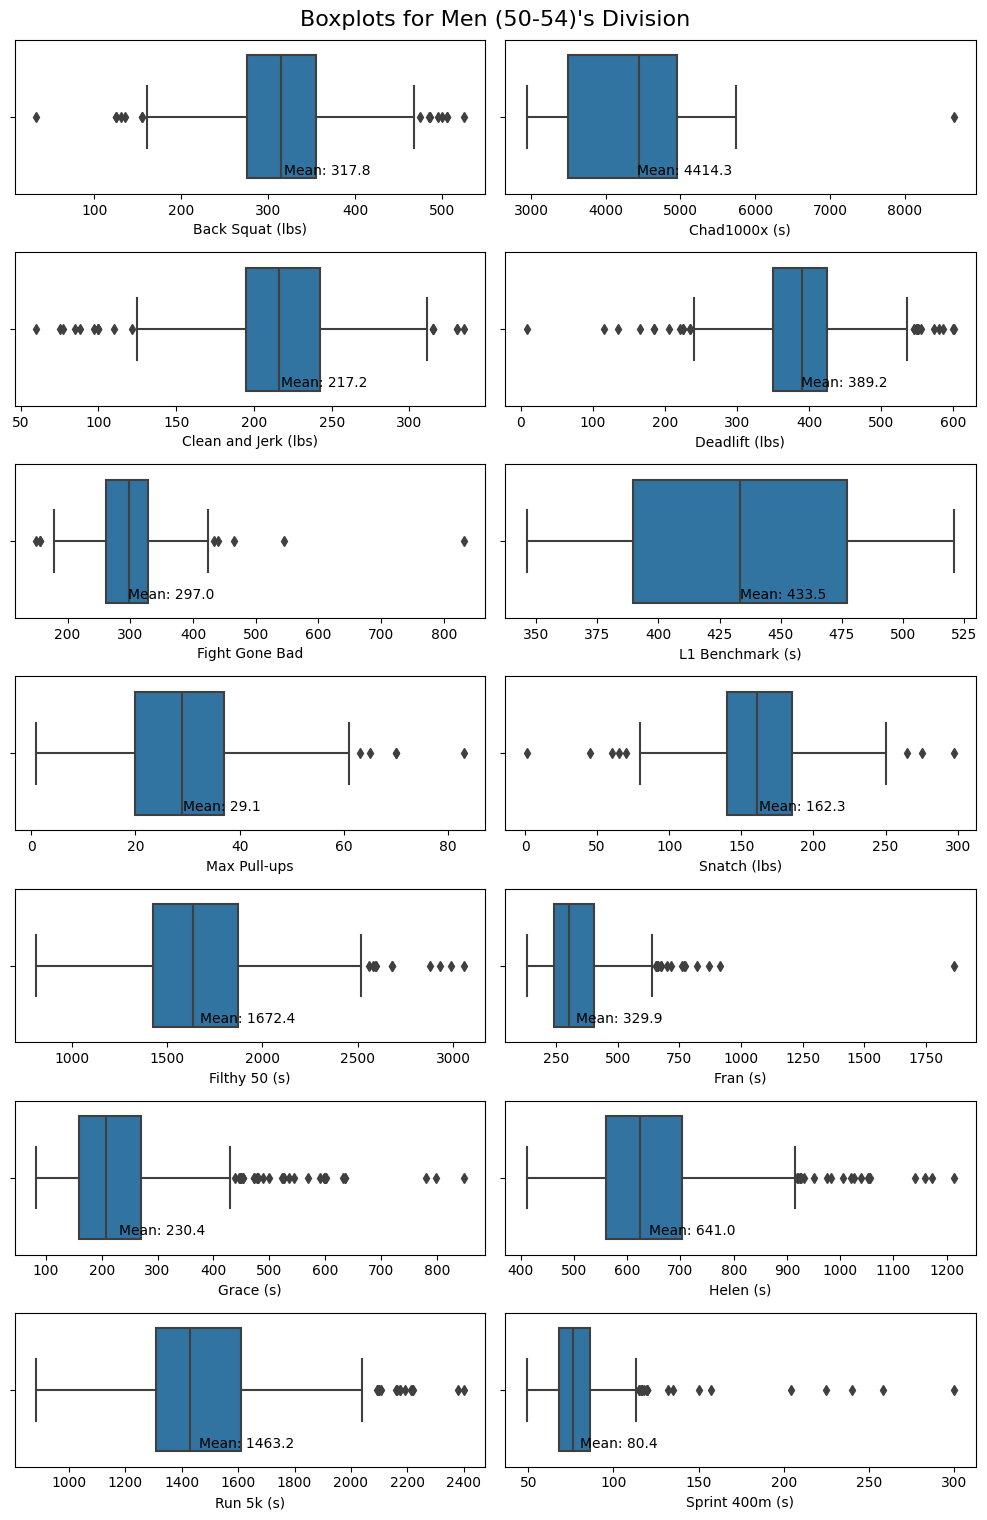

             Workout    Mean  Median     Min     25%     50%     75%     Max
    Back Squat (lbs)  317.81  315.00   33.07  275.58  315.00  355.00  525.00
       Chad1000x (s) 4414.35 4440.00 2939.00 3499.50 4440.00 4949.50 8664.00
Clean and Jerk (lbs)  217.17  216.05   60.00  195.00  216.05  242.51  335.00
      Deadlift (lbs)  389.20  390.00    8.00  350.00  390.00  425.00  601.00
      Fight Gone Bad  297.05  298.00  150.00  261.00  298.00  328.00  832.00
    L1 Benchmark (s)  433.50  433.50  346.00  389.75  433.50  477.25  521.00
        Max Pull-ups   29.12   29.00    1.00   20.00   29.00   37.00   83.00
        Snatch (lbs)  162.31  160.94    1.00  140.00  160.94  185.00  297.62
       Filthy 50 (s) 1672.44 1638.00  815.00 1429.50 1638.00 1870.25 3057.00
            Fran (s)  329.87  304.00  130.00  239.75  304.00  403.00 1864.00
           Grace (s)  230.37  208.00   83.00  160.00  208.00  270.00  848.00
           Helen (s)  640.99  624.00  411.00  560.75  624.00  702.50 1214.00

C:\Users\eunic\AppData\Local\Temp\ipykernel_31404\2413622702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats = pd.concat([summary_stats,


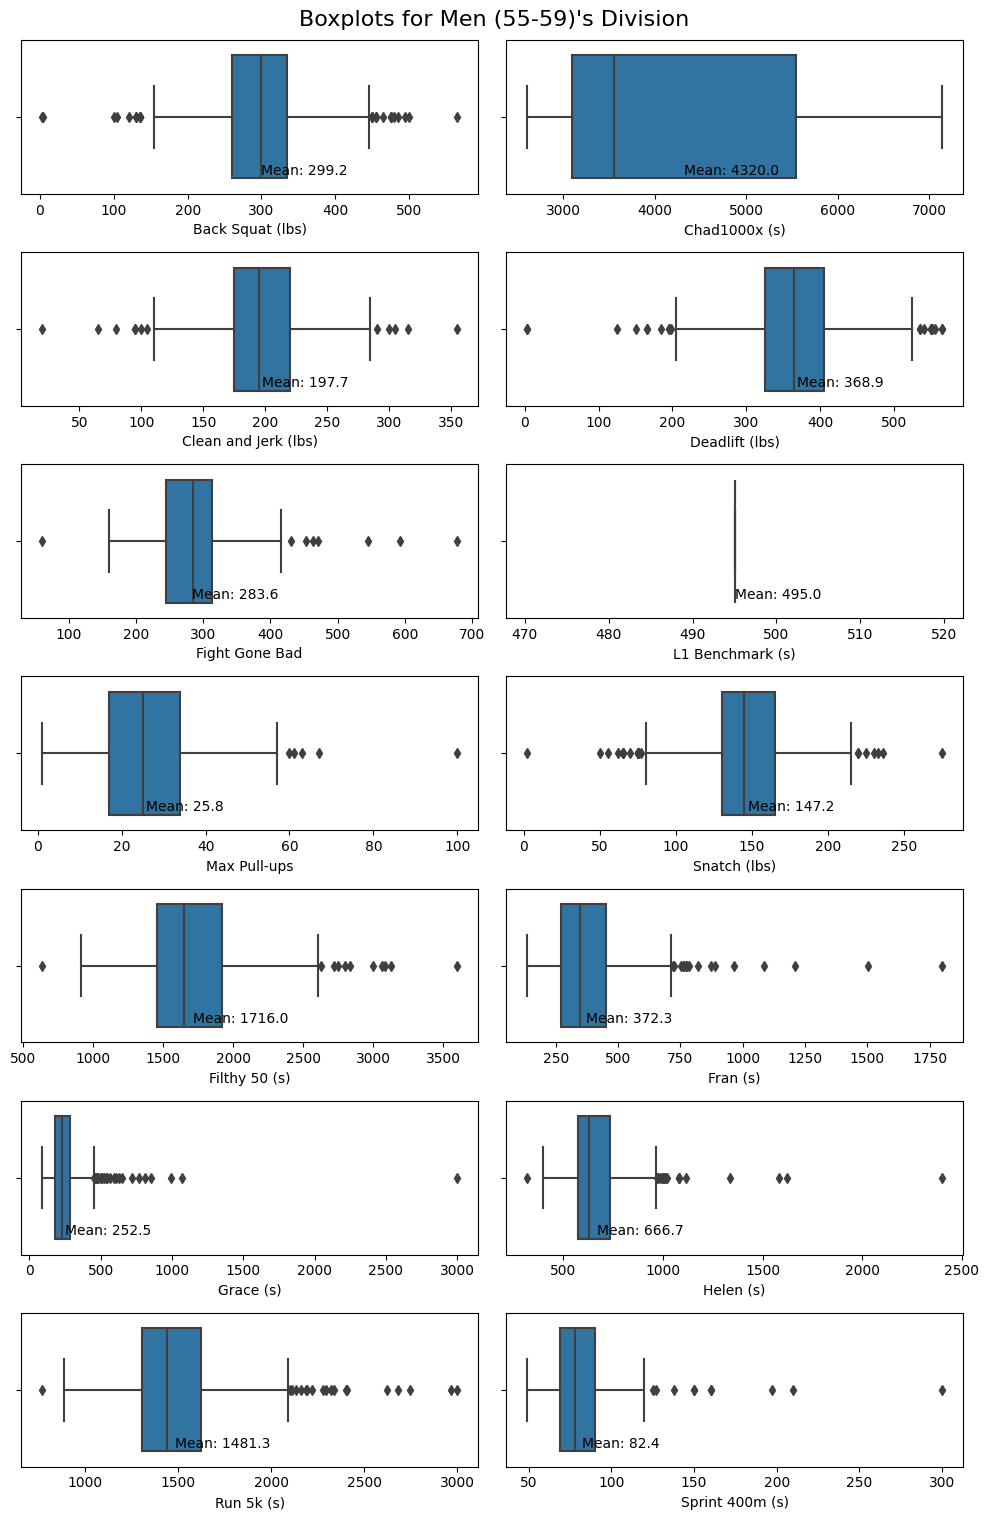

             Workout    Mean  Median    Min    25%    50%     75%    Max
    Back Squat (lbs)  299.17   300.0    3.0  260.0  300.0  335.00  565.0
       Chad1000x (s) 4320.00  3560.0 2604.0 3095.0 3560.0 5542.00 7140.0
Clean and Jerk (lbs)  197.69   195.0   20.0  175.0  195.0  220.46  355.0
      Deadlift (lbs)  368.94   365.0    3.0  325.0  365.0  405.00  565.0
      Fight Gone Bad  283.64   284.0   60.0  245.0  284.0  313.50  678.0
    L1 Benchmark (s)  495.00   495.0  495.0  495.0  495.0  495.00  495.0
        Max Pull-ups   25.85    25.0    1.0   17.0   25.0   34.00  100.0
        Snatch (lbs)  147.21   145.0    2.0  130.0  145.0  165.00  275.0
       Filthy 50 (s) 1716.01  1652.0  636.0 1457.0 1652.0 1920.00 3599.0
            Fran (s)  372.34   345.0  134.0  271.0  345.0  449.50 1800.0
           Grace (s)  252.53   230.0   90.0  178.5  230.0  288.00 3000.0
           Helen (s)  666.73   631.0  318.0  575.0  631.0  733.00 2400.0
          Run 5k (s) 1481.31  1440.0  768.0 1305.0 

C:\Users\eunic\AppData\Local\Temp\ipykernel_31404\2413622702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats = pd.concat([summary_stats,


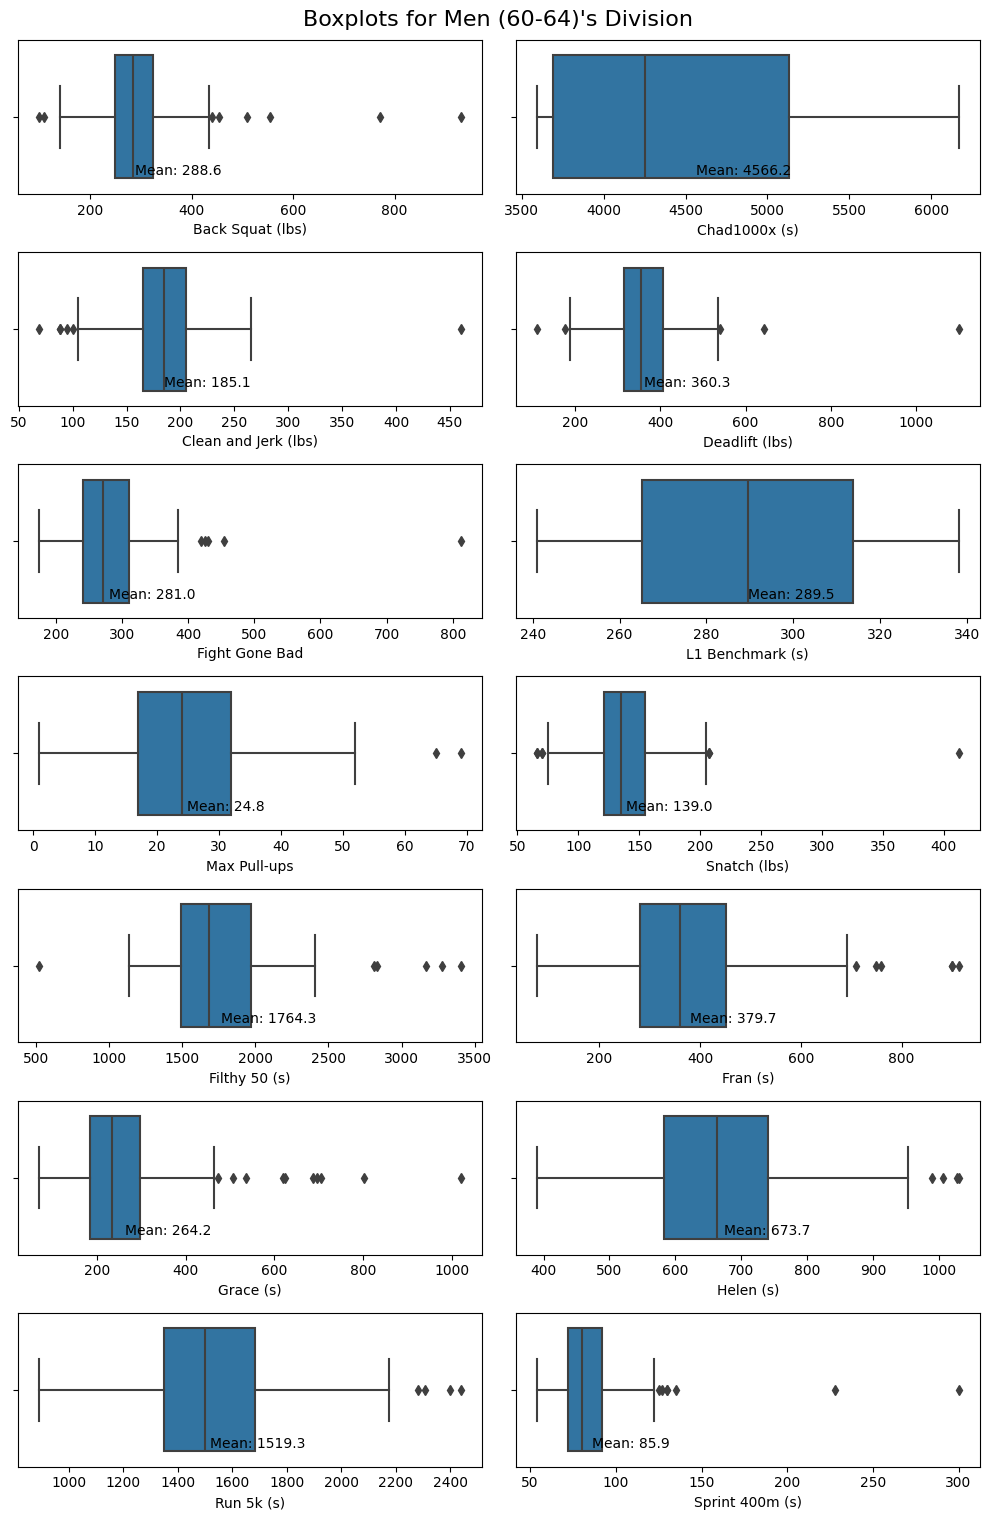

             Workout    Mean  Median     Min     25%    50%     75%    Max
    Back Squat (lbs)  288.61   285.0  100.00  250.00  285.0  325.00  930.0
       Chad1000x (s) 4566.25  4252.5 3594.00 3688.50 4252.5 5130.25 6166.0
Clean and Jerk (lbs)  185.09   185.0   69.00  165.00  185.0  205.00  460.0
      Deadlift (lbs)  360.32   355.0  110.00  315.00  355.0  405.00 1100.0
      Fight Gone Bad  281.02   272.0  175.00  241.00  272.0  311.25  812.0
    L1 Benchmark (s)  289.50   289.5  241.00  265.25  289.5  313.75  338.0
        Max Pull-ups   24.81    24.0    1.00   17.00   24.0   32.00   69.0
        Snatch (lbs)  138.98   135.0   66.14  121.25  135.0  155.00  412.0
       Filthy 50 (s) 1764.32  1682.5  525.00 1495.50 1682.5 1974.75 3404.0
            Fran (s)  379.68   359.0   76.00  281.25  359.0  451.75  913.0
           Grace (s)  264.16   235.0   70.00  185.00  235.0  298.00 1020.0
           Helen (s)  673.75   664.0  390.00  583.00  664.0  740.00 1030.0
          Run 5k (s) 1519

C:\Users\eunic\AppData\Local\Temp\ipykernel_31404\2413622702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats = pd.concat([summary_stats,
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


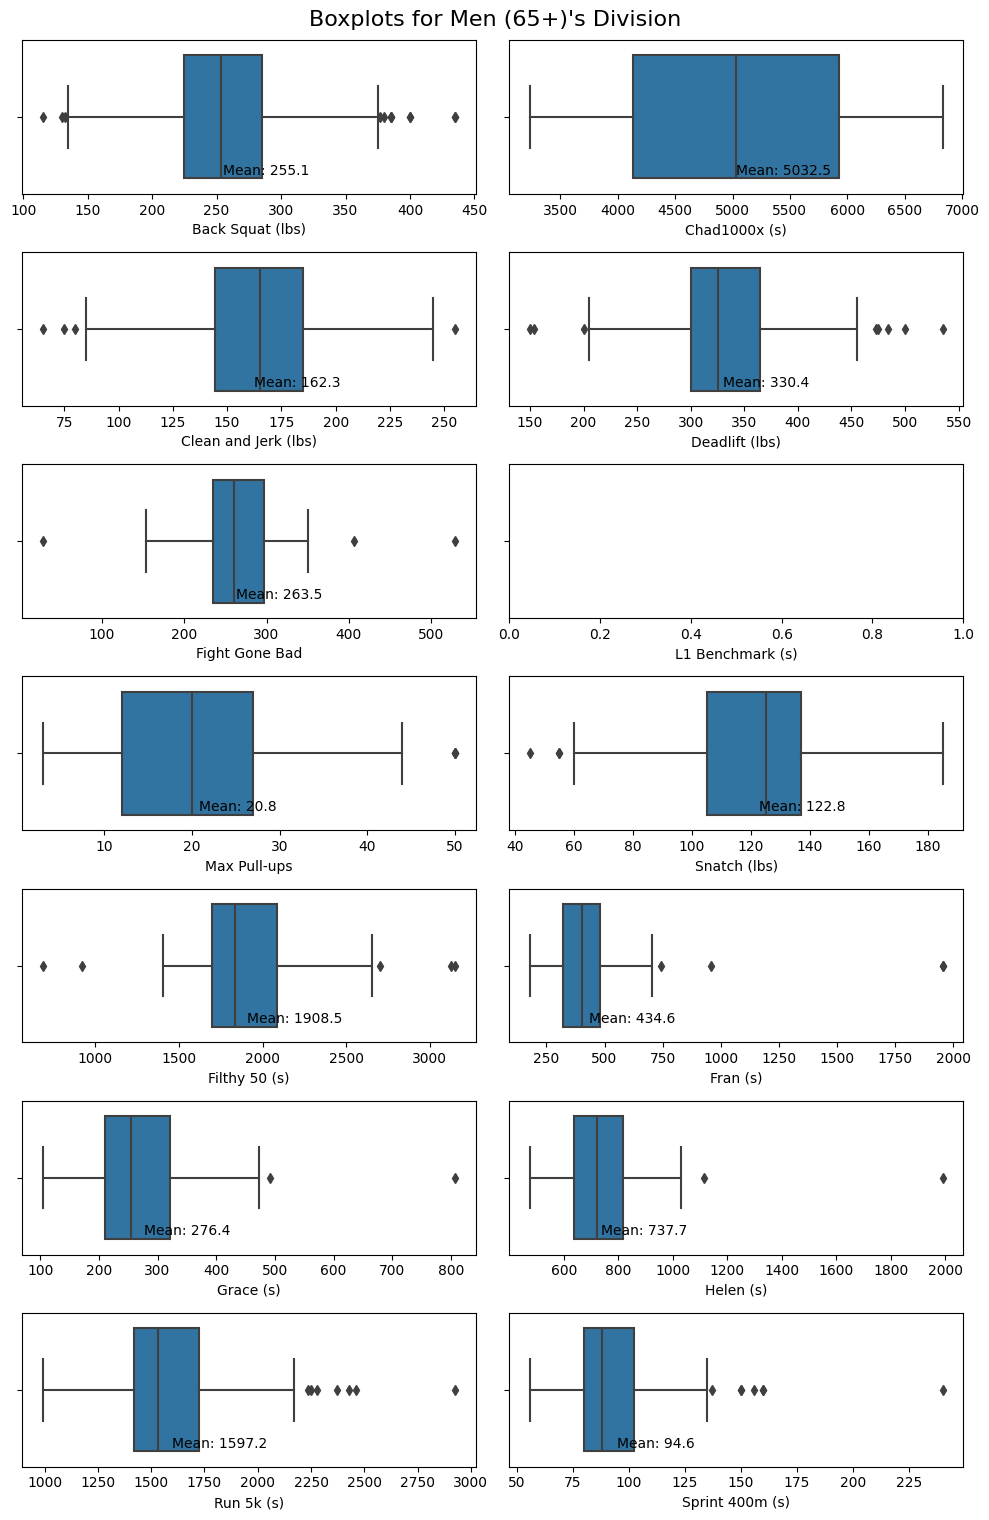

             Workout    Mean  Median    Min     25%     50%     75%    Max
    Back Squat (lbs)  255.12  253.53  115.0  225.00  253.53  285.00  435.0
       Chad1000x (s) 5032.50 5032.50 3234.0 4133.25 5032.50 5931.75 6831.0
Clean and Jerk (lbs)  162.30  165.00   65.0  144.50  165.00  185.00  255.0
      Deadlift (lbs)  330.41  325.00  150.0  300.00  325.00  365.00  535.0
      Fight Gone Bad  263.53  260.00   28.0  234.75  260.00  297.25  529.0
    L1 Benchmark (s)     NaN     NaN    NaN     NaN     NaN     NaN    NaN
        Max Pull-ups   20.78   20.00    3.0   12.00   20.00   27.00   50.0
        Snatch (lbs)  122.82  125.00   45.0  105.00  125.00  137.00  185.0
       Filthy 50 (s) 1908.53 1832.00  684.0 1697.00 1832.00 2088.00 3151.0
            Fran (s)  434.64  402.50  179.0  321.50  402.50  480.00 1955.0
           Grace (s)  276.42  255.00  104.0  210.00  255.00  322.00  807.0
           Helen (s)  737.75  723.00  476.0  639.00  723.00  816.50 1990.0
          Run 5k (s) 1597

C:\Users\eunic\AppData\Local\Temp\ipykernel_31404\2413622702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats = pd.concat([summary_stats,
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


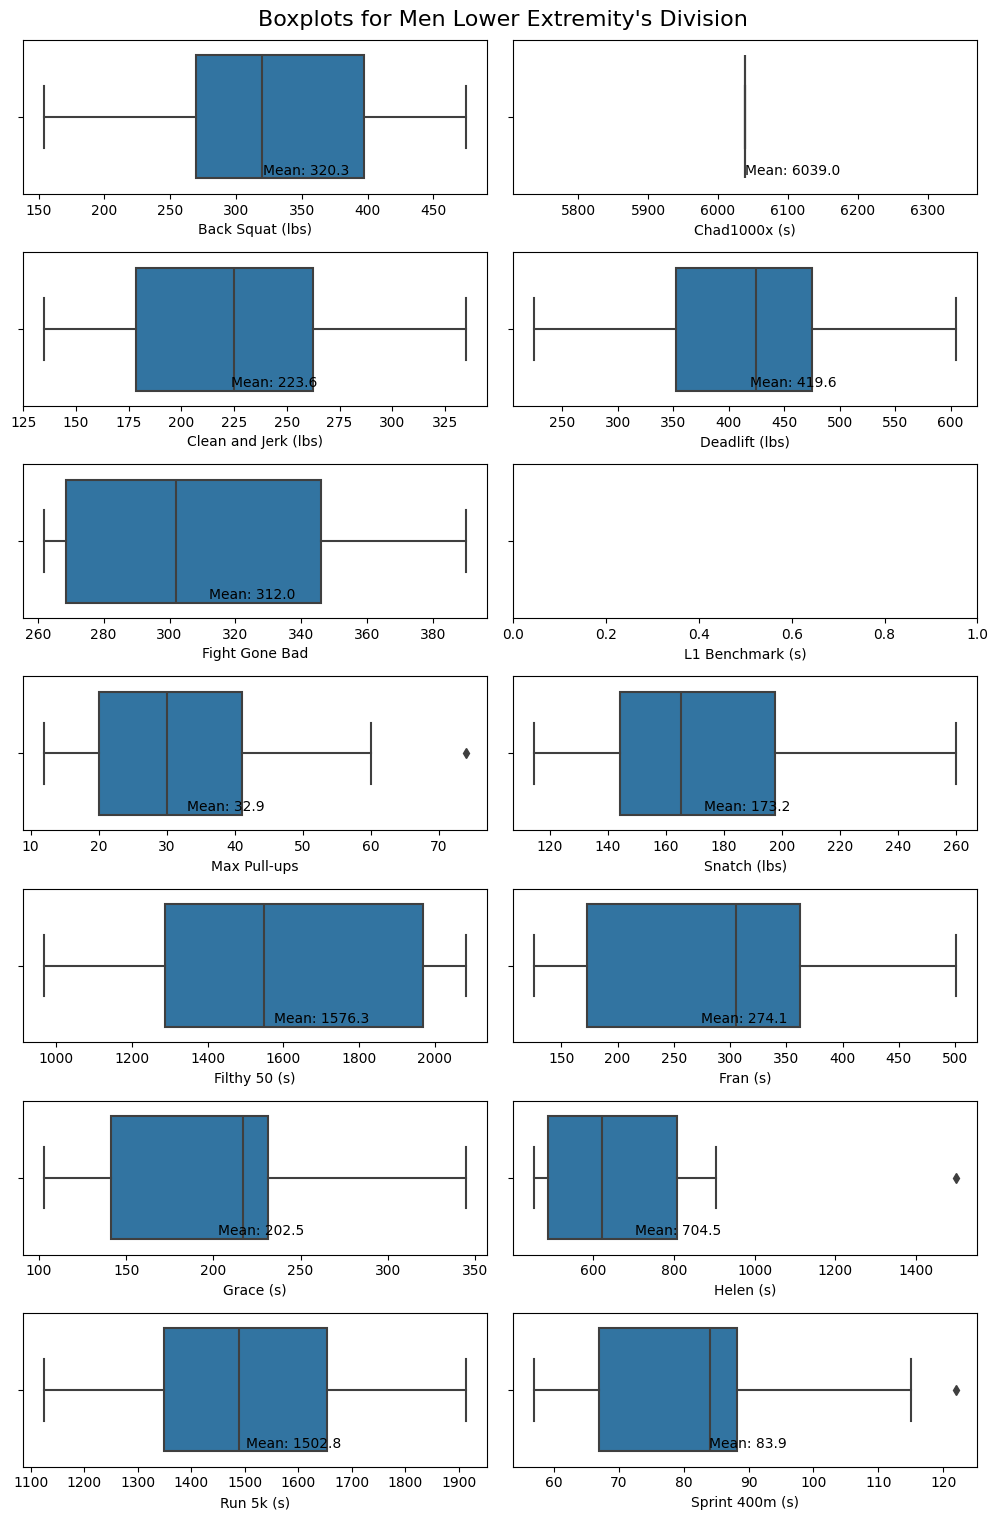

             Workout    Mean  Median     Min     25%     50%     75%    Max
    Back Squat (lbs)  320.31  319.67  154.32  270.00  319.67  397.50  475.0
       Chad1000x (s) 6039.00 6039.00 6039.00 6039.00 6039.00 6039.00 6039.0
Clean and Jerk (lbs)  223.56  224.72  135.00  178.53  224.72  262.17  335.0
      Deadlift (lbs)  419.57  425.00  225.00  352.74  425.00  475.00  605.0
      Fight Gone Bad  312.00  302.00  262.00  268.50  302.00  346.00  390.0
    L1 Benchmark (s)     NaN     NaN     NaN     NaN     NaN     NaN    NaN
        Max Pull-ups   32.95   30.00   12.00   20.00   30.00   41.00   74.0
        Snatch (lbs)  173.24  165.35  114.64  144.15  165.35  197.50  260.0
       Filthy 50 (s) 1576.33 1548.50  968.00 1287.25 1548.50 1969.50 2083.0
            Fran (s)  274.06  305.00  126.00  173.00  305.00  362.00  501.0
           Grace (s)  202.50  217.00  103.00  141.00  217.00  231.50  345.0
           Helen (s)  704.46  623.00  454.00  489.00  623.00  807.00 1500.0
          Ru

C:\Users\eunic\AppData\Local\Temp\ipykernel_31404\2413622702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats = pd.concat([summary_stats,
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


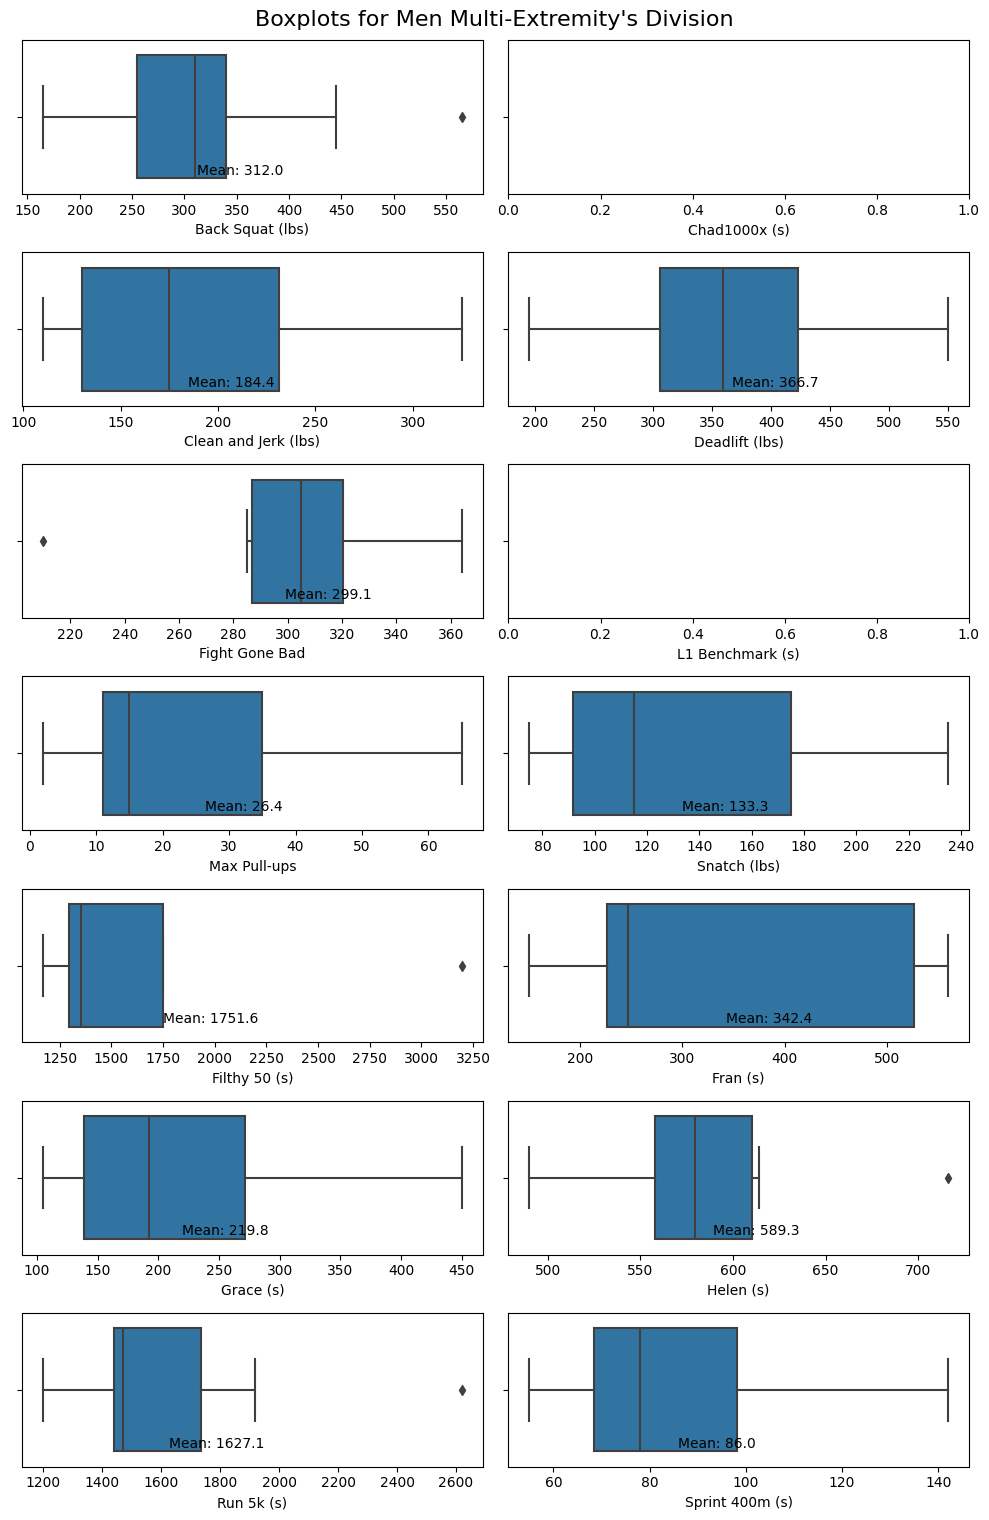

             Workout    Mean  Median     Min     25%     50%     75%    Max
    Back Squat (lbs)  312.03  310.00  165.00  255.00  310.00  340.00  565.0
       Chad1000x (s)     NaN     NaN     NaN     NaN     NaN     NaN    NaN
Clean and Jerk (lbs)  184.43  175.00  110.23  130.00  175.00  231.49  325.0
      Deadlift (lbs)  366.67  358.87  195.00  305.91  358.87  422.50  550.0
      Fight Gone Bad  299.14  305.00  210.00  287.00  305.00  320.50  364.0
    L1 Benchmark (s)     NaN     NaN     NaN     NaN     NaN     NaN    NaN
        Max Pull-ups   26.44   15.00    2.00   11.00   15.00   35.00   65.0
        Snatch (lbs)  133.30  115.00   75.00   91.59  115.00  175.00  235.0
       Filthy 50 (s) 1751.60 1352.00 1169.00 1295.00 1352.00 1747.00 3195.0
            Fran (s)  342.40  247.00  150.00  225.75  247.00  527.00  560.0
           Grace (s)  219.75  192.00  105.00  139.00  192.00  271.75  450.0
           Helen (s)  589.33  579.50  490.00  558.00  579.50  610.00  716.0
          Ru

C:\Users\eunic\AppData\Local\Temp\ipykernel_31404\2413622702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats = pd.concat([summary_stats,
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


FileNotFoundError: [Errno 2] No such file or directory: 'reports/figures/boxplot_Men Seated (w/ hip).png'

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


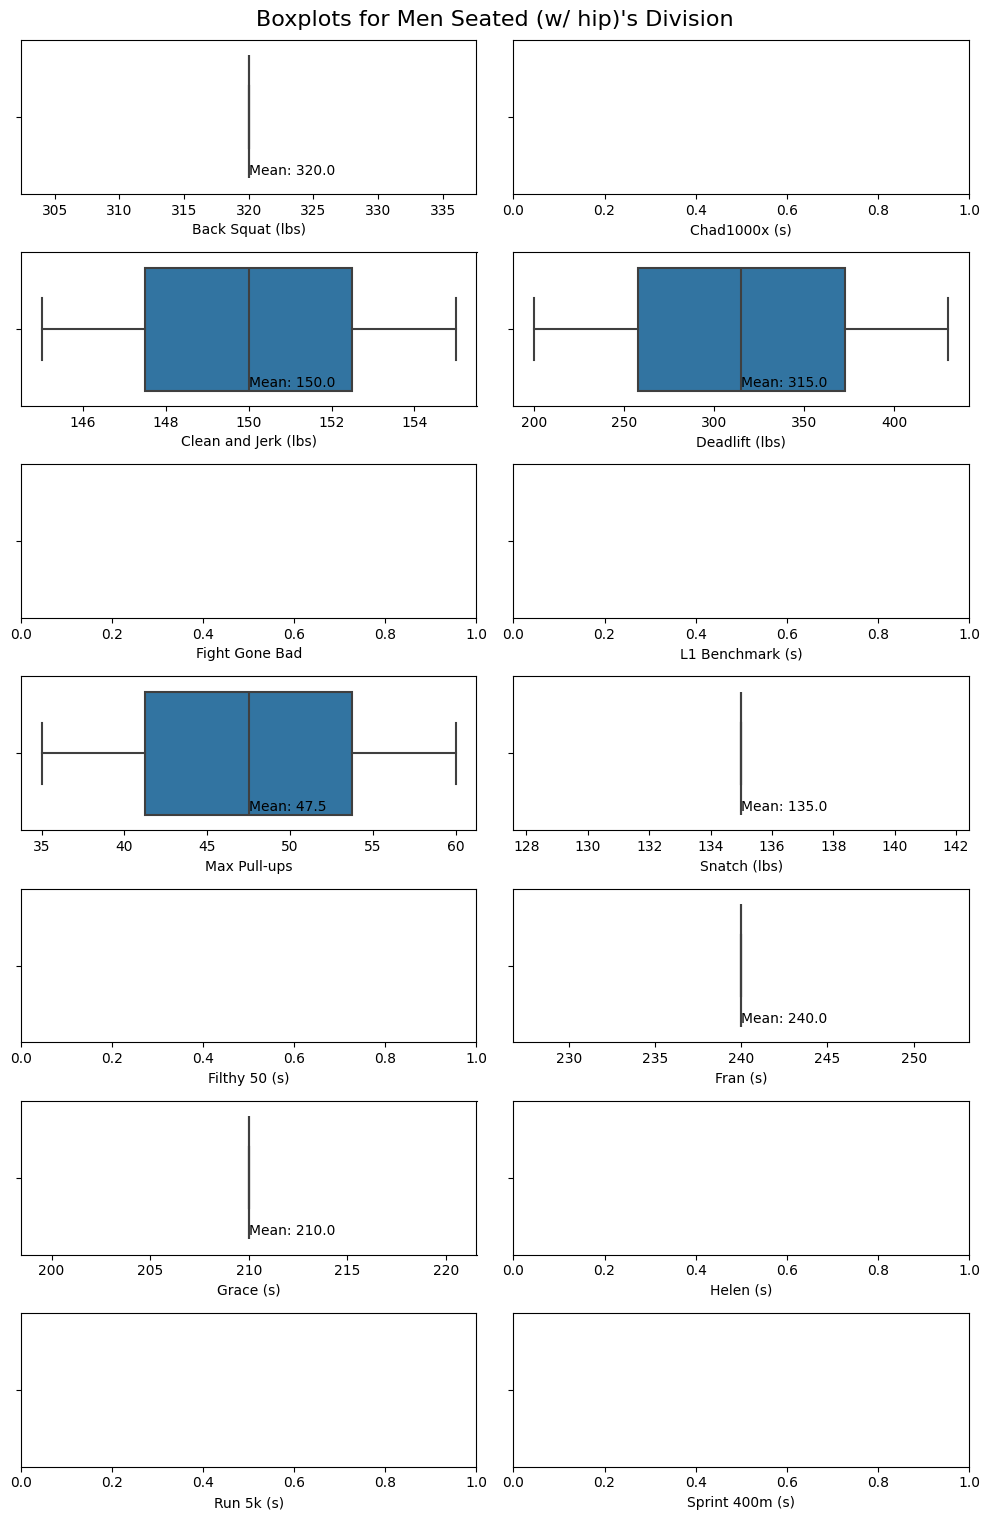

In [45]:
print_boxplots_by_division(df)

In [104]:
df.to_csv('data/processed/data_processed.csv',index=False)